TODO
- Fix the time limit on pod16w to 48 hours 
- Fix the ipython notebook running on host which kills everything
- Compress dataset (atom positions float16?) 
  - Turns out it's easier to just pad stuff when storing and have it in float32; this will require much fewer bytes than string
      how do I store float64 in pandas; can I do that with csv?
      fix dataset storing 
- Fix the hydrogen problem => run much faster for larger molecules. 
- Start running with different basis sets 
- 

With PySCF; if we're 100x faster, perhaps do something like every 100 with PySCF?
Make -pyscf argument that does it randomly, e.g., -uniform_pyscf 0.01 which does if np.random.uniform(0, 1, (1)) > args.uniform_pyscf: ... 

In [5]:
def fixstr(df):
  df["energies"]       = np.array([np.fromstring(df["energies"].values[0][1: -1], sep=",", dtype=np.float64) for i in tqdm(range(df.shape[0]))])
  df["atom_positions"] = np.array([np.fromstring(df["atom_positions"].values[0][1: -1], sep=",", dtype=np.float64) for i in tqdm(range(df.shape[0]))])
  return df 


In [75]:
# I tried a bunch of different formats. 
# pickle: doesn't allow me to append; this is a huge nogo when creating dataset 
# hdf5:   doesn't allow? ; appending required adding different keys which is annoying 
# csv:    to save numpy arrays of varying length they get stored as string(np.array(object)) which requires custom parsing when loadin
# choose .csv for dataset creation, then when we dump we can use pkl; actually hdf may be preferable, this will allow people to read only a bit of it? 
import pandas as pd 
import numpy as np 
from tqdm import tqdm 
folders = natsorted(os.listdir("../data/generated/test/"))[-1]
file = "../data/generated/test/%s/data.csv"%folders
df = pd.read_csv(file, compression="gzip")

def fixstr(df):
  df["energies"]       = np.array([np.fromstring(df["energies"].values[0][1: -1], sep=",", dtype=np.float64) for i in tqdm(range(df.shape[0]))])
  df["atom_positions"] = np.array([np.fromstring(df["atom_positions"].values[0][1: -1], sep=",", dtype=np.float64) for i in tqdm(range(df.shape[0]))])
  return df 

print(df.shape)
print(df)

# make one for each in : 
# addHs, AddExplicitHs, AddPolarHydrogens;; 

# GDB: 3*3*3 = 27 versions 
# sto3g, sto6g, 231g
# level = 0,1,2
# explicitHs, polarHs, AddHs
# rdkit addconformer versions? 

100%|██████████| 20/20 [00:00<00:00, 43554.56it/s]

(20, 13)
    Unnamed: 0                    smile      atoms  atom_positions  \
0            0       FC(F)(C#N)C(=O)C#N  FCFCNCOCN       -1.861525   
1            0         FC(F)=C(F)C#CC#N  FCFCFCCCN       -1.861525   
2            0           Fc1nnc(=O)oc1F  FCNNCOOCF       -1.861525   
3            0           Fc1nonc(F)c1=O  FCNONCFCO       -1.861525   
4            0          O=c1nc(nno1)C#N  OCNCNNOCN       -1.861525   
5            0         Fc1onc2OC(=O)c12  FCONCOCOC       -1.861525   
6            0          O=C(C#N)c1nnno1  OCCNCNNNO       -1.861525   
7            0            Fc1onc2nnoc12  FCONCNNOC       -1.861525   
8            0         Fc1onc2C(=O)Oc12  FCONCCOOC       -1.861525   
9            0  [O-][N+](=O)c1noc(=O)o1  ONOCNOCOO       -1.861525   
10           0           Fc1noc(C#N)c1F  FCNOCCNCF       -1.861525   
11           0       FC(F)=C(F)C(F)(F)F  FCFCFCFFF       -1.861525   
12           0       FC(F)(F)C(F)(F)C#N  FCFFCFFCN       -1.861525   
13         

In [4]:
def fixstr(df):
  df["energies"]       = np.array([np.fromstring(df["energies"].values[0][1: -1], sep=",", dtype=np.float64) for i in tqdm(range(df.shape[0]))])
  df["atom_positions"] = np.array([np.fromstring(df["atom_positions"].values[0][1: -1], sep=",", dtype=np.float64) for i in tqdm(range(df.shape[0]))])
  return df 



0      [-32162.002, -13353.176, -14159.097, -14228.41...
1      [-28182.809, -15883.23, -13286.664, -13937.512...
2      [-46638.586, -9420.397, -13726.514, -15191.862...
3      [-31943.625, -15323.091, -14914.195, -15736.73...
4      [-29408.959, -12134.326, -12750.736, -12229.70...
                             ...                        
474    [-30959.598, -13961.813, -15447.006, -14937.24...
475    [-29710.35, -13838.001, -13534.112, -13572.726...
476    [-29528.691, -14375.323, -15769.389, -13857.03...
477    [-29499.008, -12733.933, -13886.042, -13242.43...
478    [-26455.38, -12906.31, -11644.246, -12553.327,...
Name: energies, Length: 479, dtype: object


# [run10-14] gdb in different basis sets 


only 11 and 12 ran 

In [11]:
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 
from tqdm import tqdm 

def get_num_mols(run): 
  folders = natsorted(os.listdir("../data/generated/%s/"%run))

  mols = 0
  pbar = tqdm(folders)
  dfs = []
  for folder in pbar:
    path =  "../data/generated/%s/%s/data.csv"%(run, folder)
    if os.path.isfile(path): 
      df = pd.read_csv(path, compression="gzip")[1:] # remove first one, it has compile time in it
      dfs.append(df)
      mols += df.shape[0] 
    else: 
      continue 

    pbar.set_description(str(mols))

  from datetime import datetime
  now = datetime.now()

  current_time = now.strftime("%H:%M:%S")
  print(current_time, mols, run)

  df = pd.concat(dfs)
  df.to_pickle("../data/generated/%s/data.pkl"%run)
  return df

#get_num_mols("run10") # 
df11 = get_num_mols("run11")  # is this sto3g? did we include pyscf? if not, perhaps rerun for that. 
df12 = get_num_mols("run12")  # this is sto6g? 

print(df11.shape, df12.shape)

443506: 100%|██████████| 8/8 [00:23<00:00,  2.96s/it]


14:08:17 443506 run11


442278: 100%|██████████| 8/8 [00:23<00:00,  2.99s/it]


14:08:43 442278 run12
(443506, 13) (442278, 13)


In [2]:
import pandas as pd 
df11 = pd.read_pickle("../data/generated/run11/data.pkl")
df12 = pd.read_pickle("../data/generated/run12/data.pkl")
print(df11.shape, df12.shape)

(443506, 13) (442278, 13)


In [4]:
#for compression in [".gz", ".bz2", ".zip", ".xz", ".zst", ".tar", ".tar.gz", ".tar.xz",  ".tar.bz2"]:
for compression in ['infer', None, 'bz2', 'gzip', 'tar', 'xz', 'zip', 'zstd']: #[".gz", ".bz2", ".zip", ".xz", ".zst", ".tar", ".tar.gz", ".tar.xz",  ".tar.bz2"]:
  print(compression)
  if compression == "bz2": continue # gzip took forever
  if compression == "gzip": continue 
  df11.to_pickle("../data/generated/run11/data_%s.pkl"%compression, compression=compression)
!ls -lah "../data/generated/run11/"

# try polars 
# look at energy in sto3g and sto6g; try with other ones aswell. 
# sort gdb13

infer
None
bz2
gzip
tar
xz
zip
zstd


ImportError: Missing optional dependency 'zstandard'.  Use pip or conda to install zstandard.

In [ ]:
!ls -lah "../data/generated/run11/"

In [3]:
print(df11.keys())
print(df12.keys())

Index(['Unnamed: 0', 'smile', 'atoms', 'atom_positions', 'energies',
       'nuclear_energy', 'times', 'homo', 'lumo', 'hlgap', 'N', 'mem_eri',
       'mem_grid'],
      dtype='object')
Index(['Unnamed: 0', 'smile', 'atoms', 'atom_positions', 'energies',
       'nuclear_energy', 'times', 'homo', 'lumo', 'hlgap', 'N', 'mem_eri',
       'mem_grid'],
      dtype='object')


In [6]:
df11 = fixstr(df11) 
df12 = fixstr(df12) 

100%|██████████| 442278/442278 [00:10<00:00, 40860.98it/s]


In [8]:
df11["energies"].shape

(443506,)

In [7]:
# remove non-converged 

std = np.std(df11["energies"].values[:, -10:], axis=1)
df11["std"] = std
df11["converged"] = std < 0.01

std = np.std(df12["energies"].values[:, -10:], axis=1)
df12["std"] = std
df12["converged"] = std < 0.01




# store string used to run in log directory
# store logs... 

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import matplotlib.pyplot as plt 

#plt.plot(df12["hlgap"], df11["hlgap"], 'x', alpha=0.3)
#plt.plot(df12["hlgap"], 'x', alpha=0.3)




: 

# [run8] GDB9
might vmap stuff and make this one faster. 

In [28]:
import os 
import csv 
from natsort import natsorted 
folders = natsorted(os.listdir("../data/generated/run8/"))
print(folders)
print(len(folders))
from tqdm import tqdm 

pbar = tqdm(folders)
mols = 0 
for folder in pbar:
  file = "../data/generated/run8/%s/data.csv"%folder
  if os.path.isfile(file): file   = open(file)
  reader = csv.reader(file)
  lines  = len(list(reader))
  mols += lines 
  pbar.set_description("%i "%mols) # 1%

['0_GDB9_f32True_grid0_backendipu_55535_111069', '1_GDB9_f32True_grid0_backendipu_333210_388744', '2_GDB9_f32True_grid0_backendipu_166605_222139', '3_GDB9_f32True_grid0_backendipu_222140_277674', '4_GDB9_f32True_grid0_backendipu_0_55534', '5_GDB9_f32True_grid0_backendipu_388745_444279', '6_GDB9_f32True_grid0_backendipu_111070_166604', '7_GDB9_f32True_grid0_backendipu_277675_333209', '8_GDB9_f32True_grid0_backendipu_277675_333209', '9_GDB9_f32True_grid0_backendipu_166605_222139', '10_GDB9_f32True_grid0_backendipu_0_55534', '11_GDB9_f32True_grid0_backendipu_111070_166604', '12_GDB9_f32True_grid0_backendipu_55535_111069', '13_GDB9_f32True_grid0_backendipu_333210_388744', '14_GDB9_f32True_grid0_backendipu_388745_444279', '15_GDB9_f32True_grid0_backendipu_222140_277674']
16


18857 : 100%|██████████| 16/16 [00:00<00:00, 26.50it/s]


# [run7] gdb11

In [31]:
import os 
import csv 
from natsort import natsorted 
folders = natsorted(os.listdir("../data/generated/run7/"))
print(folders)
print(len(folders))
from tqdm import tqdm 

pbar = tqdm(folders)
mols = 0 
for folder in pbar:
  file = "../data/generated/run7/%s/data.csv"%folder
  if os.path.isfile(file): file   = open(file)
  reader = csv.reader(file)
  lines  = len(list(reader))
  mols += lines 
  pbar.set_description("%i "%mols)

['0_GDB11_f32True_grid0_backendipu_0_89040', '1_GDB11_f32True_grid0_backendipu_178082_267122', '2_GDB11_f32True_grid0_backendipu_89041_178081', '3_GDB11_f32True_grid0_backendipu_534246_623286', '4_GDB11_f32True_grid0_backendipu_445205_534245', '5_GDB11_f32True_grid0_backendipu_267123_356163', '6_GDB11_f32True_grid0_backendipu_623287_712327', '7_GDB11_f32True_grid0_backendipu_356164_445204', '8_GDB11_f32True_grid0_backendipu_712328_801368', '9_GDB11_f32True_grid0_backendipu_890410_979450', '10_GDB11_f32True_grid0_backendipu_801369_890409', '11_GDB11_f32True_grid0_backendipu_1068492_1157532', '12_GDB11_f32True_grid0_backendipu_1335615_1424655', '13_GDB11_f32True_grid0_backendipu_1424656_1513696', '14_GDB11_f32True_grid0_backendipu_979451_1068491', '15_GDB11_f32True_grid0_backendipu_1513697_1602737', '16_GDB11_f32True_grid0_backendipu_1246574_1335614', '17_GDB11_f32True_grid0_backendipu_1157533_1246573', '18_GDB11_f32True_grid0_backendipu_1602738_1691778', '19_GDB11_f32True_grid0_backendi

7636319 : 100%|██████████| 128/128 [03:44<00:00,  1.75s/it]


In [2]:
import os 
from natsort import natsorted 
from tqdm import tqdm 
import pandas as pd 

folders = natsorted(os.listdir("../data/generated/run7/"))

dfs = []
pbar = tqdm(folders)
for folder in pbar:
  path =  "../data/generated/run7/%s/data.csv"%folder
  if os.path.isfile(path): 
    dfs.append( pd.read_csv(path)[1:] )
    pbar.set_description( str( dfs[-1].shape))

df = pd.concat(dfs)
print(df.shape)

(38476, 13): 100%|██████████| 128/128 [02:09<00:00,  1.01s/it]


(7636063, 13)


In [17]:
import os 
from natsort import natsorted 
from tqdm import tqdm 
import pandas as pd 

folders = natsorted(os.listdir("../data/generated/run7/"))

dfs  = []
path =  "../data/generated/run7/%s/data.csv"%folders[0]
df   = pd.read_csv(path)[1:] 

print(df["energies"].values.astype(np.float32))



ValueError: could not convert string to float: '[-39033.46714397 -13778.21772266 -16082.90427629 -15946.5491069\n -14982.89815678 -15110.79940558 -14669.53743538 -17164.56869849\n -16275.48507104 -14947.57648204 -13935.73659655 -14035.54619913\n -13826.97247583 -14468.56625295 -15439.66760891 -13366.81350682\n -13465.98421367 -17812.11119043 -14924.22164849 -15998.71972678\n -15739.67213595 -15995.96641507 -15748.57079796 -15927.94137007\n -15922.6411812  -15906.88527015 -15920.36416929 -15917.91314843\n -15917.48820253 -15917.3078993  -15917.47102481 -15917.45583439\n -15917.4439862  -15917.44696682 -15917.45024996 -15917.44018512\n -15917.44822967 -15917.44470595 -15917.440468   -15917.43966207\n -15917.44252192 -15917.4450461  -15917.44954842 -15917.44577643\n -15917.44759118 -15917.44807801 -15917.44440299 -15917.44743195\n -15917.44296776 -15917.43969227]'

In [12]:
import pickle 
import pandas as pd 
a = pickle.load(open("../test.pickle", "rb"))
#print(a)

df = pd.DataFrame(a)

#print(df["energies"].values)

df.to_hdf("test.hdf", key="data", mode="a")
df.to_hdf("test.hdf", key="data", mode="a")

df =  pd.read_hdf("test.hdf")

print(df.shape) 

(1, 12)


/tmp/ipykernel_4113937/9557186.py:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['smile', 'atoms', 'atom_positions', 'energies', 'times'], dtype='object')]

  df.to_hdf("test.hdf", key="data", mode="a")
/tmp/ipykernel_4113937/9557186.py:11: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['smile', 'atoms', 'atom_positions', 'energies', 'times'], dtype='object')]

  df.to_hdf("test.hdf", key="data", mode="a")


In [48]:
from natsort import natsorted 
import os 
folder = natsorted(os.listdir("generated/test"))[-1]
print(folder)
import numpy as np 


dtypes = {"smile":          str  ,
                            "atoms":          str,
                            "atom_positions": np.array, 
                            "energies":       np.array, 
                            "nuclear_energy": np.float32, 
                            "times":          np.array, 
                            "homo":           np.float32,
                            "lumo":           np.float32 ,
                            "hlgap":          np.float32,
                            "N":              np.int32,
                            "mem_eri": np.int32, 
                            "mem_grid": np.int32}


a = pd.read_csv("generated/test/%s/data.csv"%folder, compression="gzip", dtype=dtypes)

a["energies"].values

126_GDB9_f32True_grid0_backendipu_0_55534


TypeError: Cannot interpret '<built-in function array>' as a data type

In [46]:
import pandas as pd
import numpy as np

# create a dictionary with NumPy arrays
data = {'a': np.array([1.0, np.nan, 3.0]), 'b': np.array([4.0, 5.0, 'invalid'])}

# save the dictionary to a CSV file
pd.DataFrame(data).to_csv('data.csv')

# load the CSV file and convert the columns to float32 dtype
dtypes = {'a': np.float32, 'b': 'object'}  # specify dtype for each column
df = pd.read_csv('data.csv', index_col=0, dtype=dtypes, na_values='invalid')

print(df.dtypes)

a    float32
b     object
dtype: object


In [24]:
import pandas as pd

# create a sample DataFrame
data = {'Name': ['John', 'Alice', 'Bob'], 'Age': [30, 25, 35]}
df = pd.DataFrame(data)

# open the HDF file in append mode
#with pd.HDFStore('my_file.h5', mode='a') as store:
#    # append the DataFrame to the file
#    store.append('my_data', df)
df.to_hdf("my_file.h5", mode="a", key="df")

In [25]:
pd.read_hdf("my_file.h5", key="df")

,Name,Age
0,John,30
1,Alice,25
2,Bob,35


In [32]:
import pandas as pd

# create a sample DataFrame
data = {'Name': ['John', 'Alice', 'Bob'], 'Age': [30, 25, 35]}
df = pd.DataFrame(data)

# append the DataFrame to the HDF file
df.to_hdf('my_file.h5', key='a', mode='a')

In [33]:
pd.read_hdf("my_file.h5", key="a")

,Name,Age
0,John,30
1,Alice,25
2,Bob,35


In [71]:
df.shape  # 

(7636063, 13)

In [15]:
df5 = pd.read_csv("gdb11_run5.csv")

In [99]:
# plot error 
df5.shape
df4 = pd.read_csv("gdb11_run4.csv")

In [105]:
import numpy as np 
df4 = df4[df4["pyscf_energy"] == df4["pyscf_energy"]] # the previosu run with pyscf energies 
df7 = df[df["smile"].isin(df4["smile"])] # our current run without pyscf energies 

print(df4.shape, df7.shape)
df4 = df4.drop_duplicates(subset="smile")
df7 = df7.drop_duplicates(subset="smile")
print(df4.shape, df7.shape)

smiles = np.intersect1d( df4["smile"].values, df7["smile"].values) # smiles that occur in both! 

df4 = df4[df4["smile"].isin(smiles)]
df7 = df7[df7["smile"].isin(smiles)]
print(df4.shape, df7.shape)



(55768, 20) (55771, 13)
(55768, 20) (55768, 13)
(55768, 20) (55768, 13)


In [106]:
df4 = df4.sort_values(by="smile")
df7 = df7.sort_values(by="smile")

In [107]:
energies = np.array([np.fromstring(df7["energies"].values[i][1:-1], sep=" ", dtype=np.float64) for i in range(df7.shape[0])])
print(energies.shape)
std = np.std(energies[:, -10:], axis=1)
df7["std"] = std

energies = np.array([np.fromstring(df4["energies"].values[i][1:-1], sep=" ", dtype=np.float64) for i in range(df4.shape[0])])
print(energies.shape)
std = np.std(energies[:, -10:], axis=1)
df4["std"] = std




(55768, 50)
(55768, 50)


42662 (55768,)
(55768,)
46000
53361


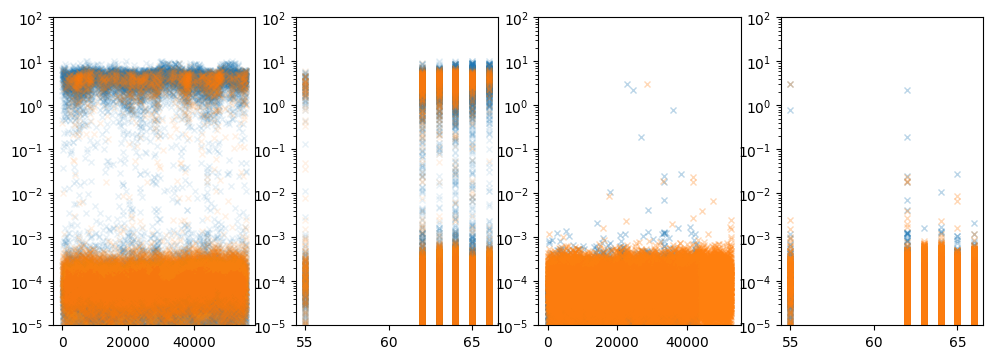

In [133]:
diff = df4["pyscf_hlgap"].values - df7["hlgap"].values
diff2 = df4["pyscf_hlgap"].values - df4["hlgap"].values

c = df7["std"] < 0.1
c2 = df4["std"] < 0.1
fig, ax = plt.subplots(1,4, figsize=(12, 4))

print(np.sum(c), c.shape)

print(c.shape)
ax[0].plot(diff, 'x',ms=5, alpha=0.1)
ax[0].plot(diff2, 'x',ms=5, alpha=0.1)
ax[0].set_yscale("log")
ax[0].set_ylim([1e-5,1e2])
ax[1].plot(df4["N"].values, diff, 'x',ms=5, alpha=0.1)
ax[1].plot(df4["N"].values, diff2, 'x',ms=5, alpha=0.1)
ax[1].set_yscale("log")
ax[1].set_ylim([1e-5,1e2])

ax[2].plot(diff[c], 'x',ms=5, alpha=0.3)
ax[2].plot(diff2[c2], 'x',ms=5, alpha=0.3)
ax[2].set_yscale("log")
ax[2].set_ylim([1e-5,1e2])
ax[3].plot(df4["N"].values[c], diff[c], 'x',ms=5, alpha=0.3)
ax[3].plot(df4["N"].values[c2], diff2[c2], 'x',ms=5, alpha=0.3)
ax[3].set_yscale("log")
ax[3].set_ylim([1e-5,1e2])

print(np.sum(diff<1e-3)) # looks like it works fine! 
print(np.sum(diff2<1e-3)) # looks like it works fine! 

# interesting; looks like less converged with the custom one; makes sense as custom one is f32 and not f64. 
# also, the latter one uses density matrix from previous iteration! 

# anyway, this looks about right. 

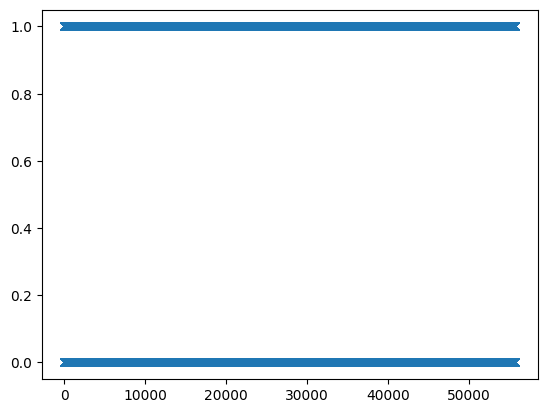

In [97]:
print(df7[:10][["smile", "hlgap", "std"]])
print(df4[:10][["smile", "pyscf_hlgap", "hlgap", "std"]])
print(df7[:10]["hlgap"].values - df4[:10]["pyscf_hlgap"].values)


                   smile     hlgap          std
6750   C#CC#CC=CC1CC1C#N  5.413428     0.002233
6608   C#CC#CC=CC1NC1C#C  5.323169     0.006481
6571   C#CC#CC=CC=CC1CC1  4.933980     0.024096
4638  C#CC#CCC1(CCN1)C#N  0.265730  2001.028114
4629  C#CC#CCC1(CCO1)C#C  0.917146  2215.482961
4642  C#CC#CCC1(CNC1)C#N  2.614519     6.289460
4630  C#CC#CCC1(COC1)C#C  6.969601     0.049267
4706  C#CC(=COC1COC1)C#N  0.830176  1234.407965
4701  C#CC(=NNC1COC1)C#N  5.664053  2181.861611
4694  C#CC(=NOC1CNC1)C#N  4.675854     0.003470
                      smile  pyscf_hlgap     hlgap          std
603111    C#CC#CC=CC1CC1C#N     5.413524  5.413243     0.004301
602969    C#CC#CC=CC1NC1C#C     5.323145  5.323038     0.005082
2288215   C#CC#CC=CC=CC1CC1     4.933968  4.933974     0.004728
1525056  C#CC#CCC1(CCN1)C#N     4.484441  4.484263     0.011589
1525047  C#CC#CCC1(CCO1)C#C     3.625875  3.626000     0.011330
1525060  C#CC#CCC1(CNC1)C#N     2.612289  2.612556     0.049742
1525048  C#CC#CCC1(COC1)

In [96]:
print(df7[-10:][["smile", "hlgap"]])
print(df4[-10:][["smile", "hlgap", "pyscf_hlgap"]])
print(df7[-10:]["hlgap"].values - df4[:10]["hlgap"].values)

                   smile     hlgap
223    n1nc2nc3nnon3c2o1  4.501675
66     n1nc2nc3onnn3c2o1  4.583981
106   n1nc2oc1C#CC#CC#C2  4.438923
487    n1nc2oc3nnoc3c2o1  5.871028
97     n1nc2oc3nnoc3n2n1  5.596359
424    n1nc2oc3onnc3c2o1  6.463111
1      n1nc2oc3onnc3n2n1  5.852808
43    n1nn2c3nonc3N=c2o1  4.869155
378  n1nnc2c(n1)c3nonc23  3.137895
571   n1oc2nc1C#CC#CC#C2  2.302197
                   smile     hlgap  pyscf_hlgap
222    n1nc2nc3nnon3c2o1  4.501873     4.501871
65     n1nc2nc3onnn3c2o1  4.584016     4.583885
105   n1nc2oc1C#CC#CC#C2  6.550130     1.278433
486    n1nc2oc3nnoc3c2o1  5.871022     5.871031
96     n1nc2oc3nnoc3n2n1  5.596430     5.596402
423    n1nc2oc3onnc3c2o1  6.463217     6.463118
0      n1nc2oc3onnc3n2n1  5.852628     5.852657
42    n1nn2c3nonc3N=c2o1  4.869026     4.869087
377  n1nnc2c(n1)c3nonc23  3.518404     3.137907
570   n1oc2nc1C#CC#CC#C2  0.105223     2.313507
[-0.91156786 -0.73905664 -0.49505178  1.3867655   1.97035929  3.85055496
 -1.11672878  

In [62]:
print(df7.keys())

Index(['Unnamed: 0', 'smile', 'atoms', 'atom_positions', 'energies',
       'nuclear_energy', 'times', 'homo', 'lumo', 'hlgap', 'N', 'mem_eri',
       'mem_grid'],
      dtype='object')


(55768, 50)


ValueError: x and y must have same first dimension, but have shapes (40286,) and (55768,)

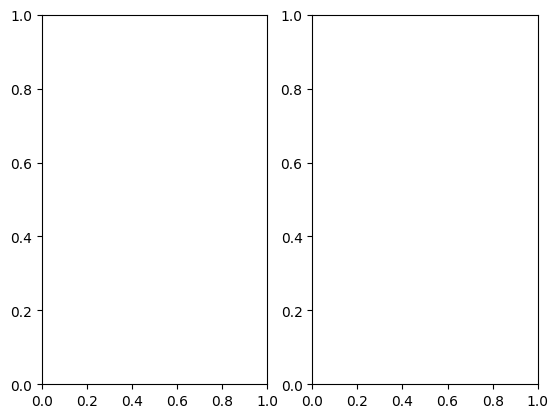

In [98]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(1,2)
#diff = np.abs(df7["hlgap"] - df4["pyscf_hlgap"])
diff7 = np.abs(df7["hlgap"].values - df4["pyscf_hlgap"].values)
diff4 = np.abs(df4["hlgap"].values - df4["pyscf_hlgap"].values)

energies = np.array([np.fromstring(df7["energies"].values[i][1:-1], sep=" ", dtype=np.float64) for i in range(df7.shape[0])])
print(energies.shape)
std = np.std(energies[:, -10:], axis=1)

c = std<0.01

df7 = df7[c]
df4 = df4[c]

plt.plot(df7["N"].values, diff7, 'x')
plt.plot(df7["N"].values, diff4, 'x')
plt.yscale("log")

In [40]:
print(df4.shape, df7.shape)

(55768, 19) (55771, 13)


In [29]:
print(pyscf.shape, smiles_pyscf.shape)

(63768, 19) (55771, 13)


In [30]:

_pyscf = pyscf[pyscf["smile"].isin(smiles_pyscf["smile"])]
print(_pyscf.shape, smiles_pyscf.shape)

smiles_pyscf = smiles_pyscf[smiles_pyscf["smile"].isin(_pyscf["smile"])]
print(_pyscf.shape, smiles_pyscf.shape)

(55768, 19) (55771, 13)
(55768, 19) (55771, 13)


In [33]:
#_pyscf.drop_duplicates(inplace=True)
#smiles_pyscf.drop_duplicates(inplace=True)

_pyscf = _pyscf[_pyscf["smile"].isin(smiles_pyscf["smile"])]

print(_pyscf.shape, smiles_pyscf.shape)

(55768, 19) (55771, 13)


KeyError:          Unnamed: 0.1  Unnamed: 0                  smile  \
0                   1           0      n1nc2oc3onnc3n2n1   
1                   2           0    Fc1onnc2=NOC(=O)c12   
2                   3           0    O=c1nc2oc(nn2o1)C#N   
3                   4           0  Fc1noc2N=C(F)C(=O)c12   
4                   5           0     Fc1oc(=O)oc1C#CC#N   
...               ...         ...                    ...   
2899708          7534           0   CC1C=CC(=C)N(O)C1=NO   
2899709          7535           0   FCC(=O)N1CCC2(CC2)O1   
2899710          7536           0   ONC(=O)N1CCC2(CC2)O1   
2899711          7537           0   CC1(N)CCC(F)(F)C1=CF   
2899712          7538           0   CN=C1C(F)C=CC(=C)N1N   

                         atoms  \
0                  NNCOCONNCNN   
1                  FCONNCNOCOC   
2                  OCNCOCNNOCN   
3                  FCNOCNCFCOC   
4                  FCOCOOCCCCN   
...                        ...   
2899708  CCCCCCNOCNOHHHHHHHHHH   
2899709  FCCONCCCCCOHHHHHHHHHH   
2899710  ONCONCCCCCOHHHHHHHHHH   
2899711  CCNCCCFFCCFHHHHHHHHHH   
2899712  CNCCFCCCCNNHHHHHHHHHH   

                                            atom_positions  \
0        [5.38279456723226, -0.8864149259942375, 0.0920...   
1        [1.2309037526421693, 4.519144675225668, 0.4819...   
2        [-7.087631769104615, -0.6312492739066408, 0.46...   
3        [-4.451824709251165, 3.2553947628306794, 0.042...   
4        [-0.7452282160828245, -1.439797016128064, 3.81...   
...                                                    ...   
2899708  [-3.5367884695311647, -3.0763781752796264, 1.0...   
2899709  [6.2449966759708815, 1.6435510891684597, 0.176...   
2899710  [8.124429541467686, -0.08452786460479114, 0.94...   
2899711  [2.638332858823164, -2.1553436758045064, -1.53...   
2899712  [-2.3567826755620414, 0.5964268483481634, -5.1...   

                                                  energies  nuclear_energy  \
0        [-39858.57527102 -13163.41751236 -16499.100234...    16377.683700   
1        [-41992.87134486 -14739.92513092 -17669.799443...    16578.607189   
2        [-39001.42800839 -13849.85847482 -15759.980772...    15380.980035   
3        [-41664.14004327 -14998.69038917 -17848.326032...    15904.777464   
4        [-38174.85389095 -15488.61350345 -15345.574326...    14075.142075   
...                                                    ...             ...   
2899708  [-38295.64327182 -12517.61011088 -14309.106603...    17287.014309   
2899709  [-40659.71021326 -14495.43590251 -15000.869923...    17843.575386   
2899710  [-40082.85745598 -14236.10056114 -14829.094001...    17604.949428   
2899711  [-43944.80679341 -15400.74120886 -16479.636295...    19160.652250   
2899712  [3.84842560e+54 7.74026794e+25 6.66145068e+25 ...    17245.081527   

                                                     times          homo  \
0        [  3.7   2.5 615.8  50.7 139.5  47.5  57.6  18... -5.988019e+00   
1        [  4.7   4.  609.2  47.5  76.1  52.2  50.5  16... -4.268928e+00   
2        [  4.3   3.9 555.7  59.2 140.5  40.2  54.1  28... -4.573568e+00   
3        [  3.8   3.8 567.6  46.7  96.9  42.   72.    5... -4.596171e+00   
4        [  6.2   3.5 492.8  48.7  94.7  43.7  68.8   6... -4.327615e+00   
...                                                    ...           ...   
2899708  [   9.     3.3 1437.4  227.5  146.8   82.9   3... -2.122414e+00   
2899709  [   7.5    3.7 1346.3  244.6   78.7   95.4   2... -2.777056e+00   
2899710  [   7.4    3.4 1302.3  238.2   94.2   59.7   6... -2.467720e+00   
2899711  [   6.8    3.9 1464.2  231.2  102.1   53.9   5... -3.279624e+00   
2899712  [   7.8    3.1 1240.8  206.9  177.2   83.8   3...  2.492557e+17   

                 lumo         hlgap   N    mem_eri  mem_grid  pyscf_time  \
0       -1.353911e-01  5.852628e+00  55   73205000  44200000    4.599429   
1       -1.103153e+00  3.165775e+00  55   73205000  44200000    5.177008   
2       -7.031740e-01  3.870394e+00  55   73205000  44200000    4.774768   
3       -1.189161e+00  3.407010e+00  55   73205000  44200000    4.737409   
4        3.564030e-01  4.684018e+00  55   73205000  44200000    5.003635   
...               ...           ...  ..        ...       ...         ...   
2899708  1.928709e+00  4.051122e+00  65  142805000  52200000    5.179967   
2899709  3.294040e+00  6.071096e+00  65  142805000  52200000    4.897747   
2899710  4.509882e+00  6.977602e+00  65  142805000  52200000    4.689598   
2899711  3.198872e+00  6.478496e+00  65  142805000  52200000    4.580486   
2899712  2.563984e+17  7.142725e+15  65  142805000  52200000    5.614476   

         pyscf_energy  pyscf_homo  pyscf_lumo  pyscf_hlgap  
0       -15917.450644   -5.987699   -0.135042     5.852657  
1       -17226.366980   -4.268312   -1.102839     3.165473  
2       -16019.424567   -4.573152   -0.702891     3.870261  
3       -17440.029852   -4.595641   -1.188741     3.406900  
4       -16335.516880   -4.327321    0.356713     4.684034  
...               ...         ...         ...          ...  
2899708 -14295.668621   -2.122101    1.929004     4.051105  
2899709 -15504.313921   -2.776642    3.294539     6.071181  
2899710 -15291.365204   -2.467244    4.510366     6.977611  
2899711 -16822.648890   -3.279260    3.199464     6.478724  
2899712 -14406.833789   -3.338434    1.690918     5.029352  

[55768 rows x 19 columns]

In [ ]:
(smile, atom_pos, rdkit_properties_27, edge_features, hlgap) # 25 atoms * 3 = 75

# 

# get features from rdkit from this, is it deterministic?
# need to create conformer inside rdkit
# 27 things: 27 integers     
# 
# edge_features: 5 possible edge features, edges corresponds to bonds as defined in3sSMILE string  ;; |E| > |V| 0 floats 

In [25]:
import pandas as pd 
import numpy as np 
folders = natsorted(os.listdir("../data/generated/run7/"))
file = "../data/generated/run7/%s/data.csv"%folders[1]
df = pd.read_csv(file)
times = np.array([np.fromstring(df["times"].values[i][1:-1], sep=" ", dtype=np.float64) for i in range(df.shape[0])])
print(times.shape)

(17769, 8)


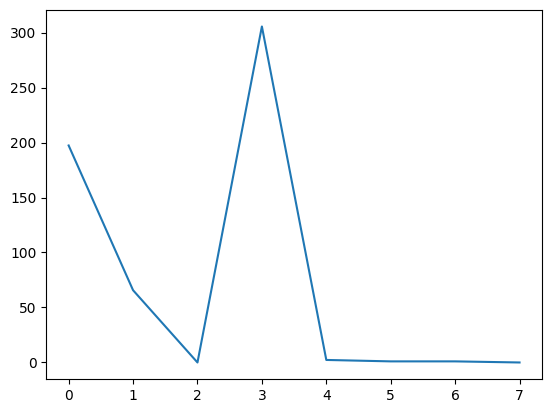

In [27]:
import matplotlib.pyplot as plt 

plt.plot(np.median(times.T, axis=1))

# [run 5] GDB11 (4/3/2023)
Similar to run4 but use -seperate strategy to allow us to do `int2e_sph` on IPU instead of CPU (it started taking 2 seconds and takes ~100 ms on IPU using 1thread). 

Observations 
- Running 255 256 took 12-17 min to compile and all cases -threads {1,2,3,4,5,6} died. Using more threads decreased compile time. 
- Running 0 256 took 


[##################################################] 100% Compilation Finished [Elapsed: 00:04:34.1]
[##################################################] 100% Compilation Finished [Elapsed: 00:04:40.1]                                                            


The time is dominated by  dft around 250 ms; getting around 1.5 iter/s ;; 
```
3.6 3.1 0.3 54.5 100.6 60.5 51.4 32.6 14.5 25.6 0.1 73.9 2.2 17.4 259.3 4.0
-633.108886 3.7 4.1 0.3 57.0 130.6 86.4 44.4 4.7 3.7 24.5 0.2 77.8 2.4 22.3 475.
```

the previous one is  1.43 s / iter. 

```
.422128 14.0 4.7 726.0 79.4 78.1 87.2 32.3 3.8 3.4 34.9 13.5 257.1 11.2: 

```



```
# eri 0 hydrogens. 
[((32422, 1), 0.129688), ((61576, 3), 0.738912), ((46238, 9), 1.664568), ((15972, 27), 1.724976), ((2214, 81), 0.717336)]
# 5 hydrogens 
[((72081, 1), 0.288324), ((112724, 3), 1.352688), ((69355, 9), 2.49678), ((19604, 27), 2.117232), ((2214, 81), 0.717336)]
# 16 hydrogens
[((178039, 1), 0.712156), ((223156, 3), 2.677872), ((109576, 9), 3.944736), ((24689, 27), 2.666412), ((2214, 81), 0.717336)]
```
the hydrogens ends up killing memory consumption, not sure why, aught to be fixable, a bit confused by that. previous was with -threads 6, trying -threads 3

- numerical precision looks ok; 

interesting point: is it really true integrals compile/run fast but ipu_mult doesn't? this is very surprisign, especially since integrals only use a single thread. the matrix/vec mult should be faster than integral computation. something is not right => can likely speed up a lot ; in other words this may be a very good thing! 



In [2]:
import matplotlib.pyplot as plt # 10 hours pod32?
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 
from tqdm import tqdm 

def get_num_mols(): 
  folders = natsorted(os.listdir("../data/generated/run5/"))

  mols = 0
  pbar = tqdm(folders)
  for folder in pbar:
    path =  "../data/generated/run5/%s/data.csv"%folder
    if os.path.isfile(path): 
      df =  pd.read_csv(path)[1:] # remove first one, it has compile time in it
      mols += df.shape[0] 
    else: 
      continue 

    pbar.set_description(str(mols))

  from datetime import datetime
  now = datetime.now()

  current_time = now.strftime("%H:%M:%S")
  print("Current Time =", current_time)

  print(mols)

get_num_mols() # stopped a  4:am due to time limit, would've had ~ 1 M more. 

739908: 100%|██████████| 61/61 [00:17<00:00,  3.41it/s]

Current Time = 09:39:42
739908


In [4]:
import os 
from natsort import natsorted 
from tqdm import tqdm 
import pandas as pd 

folders = natsorted(os.listdir("../data/generated/run5/"))

dfs = []
pbar = tqdm(folders)
for folder in pbar:
  path =  "../data/generated/run5/%s/data.csv"%folder
  if os.path.isfile(path): 
    dfs.append( pd.read_csv(path)[1:] )
    pbar.set_description( str( dfs[-1].shape))

df = pd.concat(dfs)


(50935, 13): 100%|██████████| 61/61 [00:18<00:00,  3.34it/s]


In [5]:
df.to_csv("gdb11_run5.csv")

In [7]:
df.to_csv("gdb11_run5_compressed.csv", compression="gzip") # saving compressed takes longer?

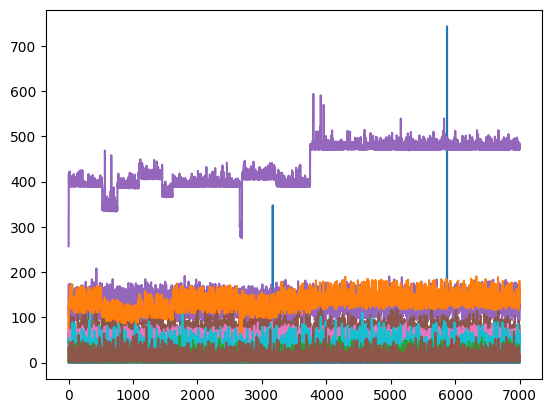

In [19]:
# fix bug in sep which doesn't recompile at some point; remove float shape perhaps? if we log this in the data it'll be easier to monitor
# finish gdb10 and gdb11, then do gdb13 without hydrogens, those seem like theyr'e the tricky ones.
# what happens to hlgap? 
import numpy as np  # what if we do gdb13 without hydrogens?
times = [np.fromstring(df["times"].values[100*i+1][1:-1], sep=" ", dtype=np.float64) for i in range(7000)]

import matplotlib.pyplot as plt 
plt.plot(times)


# [run4] GDB11 (4/3/2023)
**Idea:** Start generating only the first chunk, i.e., the ones with fewer hydrogens. If we spend say 128 IPUws on the first chunk we should be able to get a lot! 

Observations
- typical time of previous (e.g. add 12 Hs) is 1.9s int2e, 0.3s init dm, 400ms us.  (total 2.9s); removing int2e gets to ~ 1s, removing init_dm gets to ~500ms?
  

i guess if we just have 2x the data of PCQ it'll be interesting, so aim for doing the first 10M? Perhaps start 256 IPUs for that then? 

perhaps we can fix the hydrogen stuff by 



In [56]:
import matplotlib.pyplot as plt # 10 hours pod128
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 
from tqdm import tqdm 

def get_num_mols(): 
  folders = natsorted(os.listdir("../data/generated/run4/"))

  mols = 0
  pbar = tqdm(folders)
  for folder in pbar:
    path =  "../data/generated/run4/%s/data.csv"%folder
    if os.path.isfile(path): 
      df =  pd.read_csv(path)[1:] # remove first one, it has compile time in it
      mols += df.shape[0] 
    else: 
      continue 

    pbar.set_description(str(mols))

  from datetime import datetime
  now = datetime.now()

  current_time = now.strftime("%H:%M:%S")
  print("Current Time =", current_time)

  print(mols)

get_num_mols() # stopped a  4:am due to time limit, would've had ~ 1 M more. 

3126273: 100%|██████████| 174/174 [01:15<00:00,  2.30it/s]

Current Time = 08:54:08
3126273


In [48]:
get_num_mols()

100%|██████████| 158/158 [00:01<00:00, 84.90it/s] 

Current Time = 12:58:55
13432


In [49]:
get_num_mols() # 200k/hour; 24 4.8m; two days ~ 10 m. 

100%|██████████| 158/158 [00:07<00:00, 21.94it/s]

Current Time = 13:31:30
109435


In [50]:

get_num_mols()

100%|██████████| 174/174 [00:17<00:00, 10.11it/s]

Current Time = 14:56:07
380197


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

fig, ax = plt.subplots(1,4, figsize=(12,4))
i = 0
for df in tqdm(dfs):  # find the ones that ran pyscf 
  if "pyscf_time" in [str(a) for a in df.keys()]:
    print(df.keys)

    diff = np.abs(df["pyscf_hlgap"]-df["hlgap"])
    ax[0].plot(diff)
    energies = [np.fromstring( df["energies"][i][1:-1], sep=" ", dtype=np.float64)[-10:] for i in range(df.shape[0])]
    std = np.std(energies, axis=1)
    ax[2].plot(std)
    ax[1].plot(diff[std<0.5])
    ax[3].plot(df["pyscf_hlgap"][std>1], "C%io"%i, ms=5)
    ax[3].plot(df["hlgap"][std>1], "kx", ms=2)

    i+=1

for a in ax:
  a.set_yscale("log")
  a.set_ylim([1e-5, 1e1])
ax[0].set_ylabel("np.abs(hlgap_us-hlgap_pyscf) [eV]")

ax[0].set_title("all molecules")
ax[1].set_title("converged molecules")
ax[2].set_title("np.std(energy[-10:])")

plt.tight_layout()

In [4]:
folders = natsorted(os.listdir("../data/generated/run4/"))

dfs = []
mols = 0
pbar = tqdm(folders)
for folder in pbar:
  path =  "../data/generated/run4/%s/data.csv"%folder
  if os.path.isfile(path):  dfs.append(pd.read_csv(path)[1:]) # remove first one, it has compile time in it

df = pd.concat(dfs)

print(df.shape)
df.to_csv("gdb11_run4.csv")

100%|██████████| 174/174 [01:32<00:00,  1.88it/s]


In [ ]:
print(df.shape)
df.to_csv("gdb11_run4.csv")

# [test] GDB9 GDB10

Had a bug in the timing of running stuff, basically, I did 
```
times = np.array(times)
times = np.around(times[1:] - times[:-1], 2)*1000

dct = {times: [times[1:] - times[:-1]]}
```
After fixing I could quickly rerun because the binarys we're precompiled. 

['2_GDB9_f32True_grid0_backendipu_0_6940', '3_GDB9_f32True_grid0_backendipu_437283_444223', '4_GDB10_f32True_grid0_backendipu_3065076_3113727', '5_GDB10_f32True_grid0_backendipu_0_48651']
4
(25, 13)
(5, 13)
(6, 13)
(16, 13)


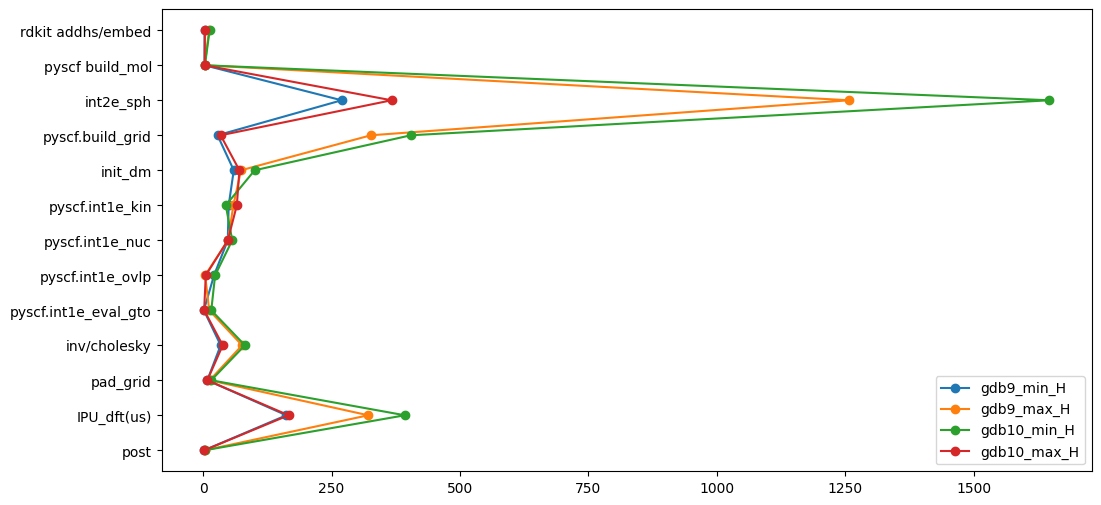

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(12,6))
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

folders = natsorted(os.listdir("../data/generated/test/"))[2:]
print(folders)
print(len(folders))

label = ["gdb9_min_H", "gdb9_max_H", "gdb10_min_H", "gdb10_max_H"]

dfs = []
i = 0 
for folder in folders:
  path =  "../data/generated/test/%s/data.csv"%folder
  if os.path.isfile(path): 
    df =  pd.read_csv(path)[1:] # remove first one, it has compile time in it
  else: 
    continue 

  print(df.shape)
  #df["times"] 

  times = np.array([np.fromstring(df["times"].values[i][1:-1], sep=" ", dtype=np.float32) for i in range(df.shape[0])])
  plt.plot(np.median(times, axis=0), -np.arange(times.shape[1]), 'C%i-o'%i, label=label[i])


  i+=1

ax.set_yticks(-np.arange(times.shape[1]), 
              [ "rdkit addhs/embed", "pyscf build_mol", "int2e_sph", "pyscf.build_grid", "init_dm", "pyscf.int1e_kin",
      "pyscf.int1e_nuc", "pyscf.int1e_ovlp", "pyscf.int1e_eval_gto", "inv/cholesky", "pad_grid", "IPU_dft(us)", "post"
      ]
    )

ax.legend()

plt.show()

(70, 13)


0     [     500.   234300.  -209200.    59100.   -58...
1     [  -1300.  240800. -215000.    9500.   19200. ...
2     [   1000.  276400. -252300.   19600.   11700. ...
3     [    800.  264900. -240400.   20100.   22200. ...
4     [  -1400.  267400. -242300.   33700.  -10100. ...
                            ...                        
12    [  5.2   3.6 362.3  34.3  99.2  66.8  45.6   7...
13    [  4.9   3.7 347.   34.5  61.8 103.2  20.5   0...
14    [  2.7   3.  372.5  34.4  82.7  84.8  35.2   0...
15    [  3.6   3.7 360.2  34.1  80.4  58.9  39.6  24...
16    [  3.8   2.9 378.7  33.8  70.9  59.8  52.    7...
Name: times, Length: 70, dtype: object

# [run3] GDB10


In [3]:
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

folders = natsorted(os.listdir("../data/generated/run3/"))[-64:]
print(folders)
print(len(folders))

df = pd.read_csv( "../data/generated/run3/%s/data.csv"%folders[2])
df2 = pd.read_csv( "../data/generated/run3/%s/data.csv"%folders[3])
print(df.keys())

['50_GDB10_f32True_grid0_backendipu_48652_97303', '51_GDB10_f32True_grid0_backendipu_97304_145955', '52_GDB10_f32True_grid0_backendipu_389216_437867', '53_GDB10_f32True_grid0_backendipu_194608_243259', '54_GDB10_f32True_grid0_backendipu_340564_389215', '55_GDB10_f32True_grid0_backendipu_291912_340563', '56_GDB10_f32True_grid0_backendipu_0_48651', '57_GDB10_f32True_grid0_backendipu_243260_291911', '58_GDB10_f32True_grid0_backendipu_681128_729779', '59_GDB10_f32True_grid0_backendipu_145956_194607', '60_GDB10_f32True_grid0_backendipu_437868_486519', '61_GDB10_f32True_grid0_backendipu_583824_632475', '62_GDB10_f32True_grid0_backendipu_535172_583823', '63_GDB10_f32True_grid0_backendipu_729780_778431', '64_GDB10_f32True_grid0_backendipu_486520_535171', '65_GDB10_f32True_grid0_backendipu_632476_681127', '66_GDB10_f32True_grid0_backendipu_924388_973039', '67_GDB10_f32True_grid0_backendipu_1362256_1410907', '68_GDB10_f32True_grid0_backendipu_1264952_1313603', '69_GDB10_f32True_grid0_backendipu_

In [4]:
print(df.shape, df2.shape)

(34728, 13) (39859, 13)


In [115]:
from tqdm import tqdm
dfs = []
for folder in tqdm(folders):
  dfs.append(pd.read_csv( "../data/generated/run3/%s/data.csv"%folder))

In [ ]:
dfs[0].shape

In [112]:
df = pd.concat(dfs)
print(df.shape)

(1645141, 20)


<bound method NDFrame.keys of       Unnamed: 0                 smile         atoms  \
0              0      Fc1nc(F)c(F)nc1F    FCNCFCFNCF   
1              0      Fc1nnoc(=O)c1C#N    FCNNOCOCCN   
2              0    O=C1OC(=O)c2onnc12    OCOCOCONNC   
3              0  O=C1OC(=O)C(=O)OC1=O    OCOCOCOOCO   
4              0    Fc1oc(=O)c(=O)oc1F    FCOCOCOOCF   
...          ...                   ...           ...   
3726           0      N#CC#CC1=NN=CON1  NCCCCNNCONHH   
3727           0       FC(C=O)c1nonc1F  FCCOCNONCFHH   
3728           0    O=c1nnc2cnnn2[nH]1  OCNNCCNNNNHH   
3729           0   O=C(Oc1ncn[nH]1)C#N  OCOCNCNNCNHH   
3730           0       O=c1cnc2nncn2o1  OCCNCNNCNOHH   

                                         atom_positions  \
0     [-4.381219578131164, 1.9841951379763392, 1.866...   
1     [0.5884497244920933, 4.451578243782718, -0.138...   
2     [-2.754032278590465, -4.262188462761692, 0.177...   
3     [4.501420360469563, -2.355243170410328, 0.0405...   
4 

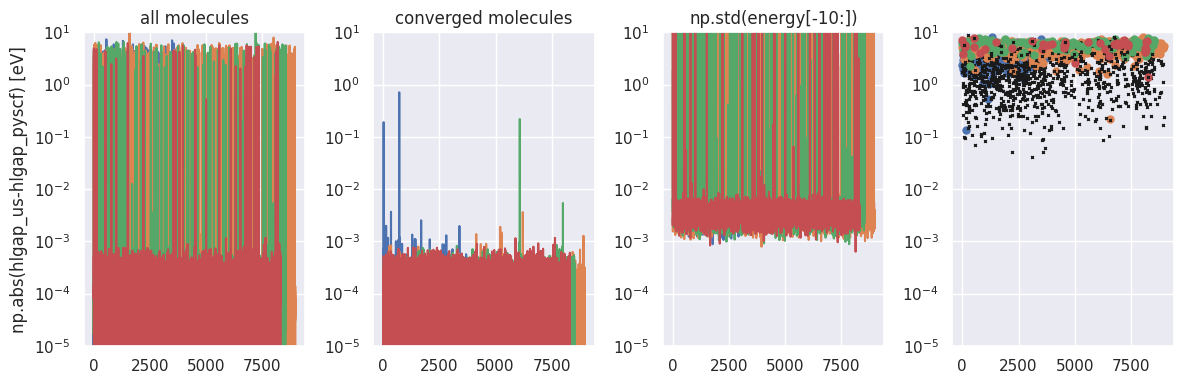

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

fig, ax = plt.subplots(1,4, figsize=(12,4))
i = 0
for df in tqdm(dfs):  # find the ones that ran pyscf 
  if "pyscf_time" in [str(a) for a in df.keys()]:
    print(df.keys)

    diff = np.abs(df["pyscf_hlgap"]-df["hlgap"])
    ax[0].plot(diff)
    energies = [np.fromstring( df["energies"][i][1:-1], sep=" ", dtype=np.float64)[-10:] for i in range(df.shape[0])]
    std = np.std(energies, axis=1)
    ax[2].plot(std)
    ax[1].plot(diff[std<0.5])
    ax[3].plot(df["pyscf_hlgap"][std>1], "C%io"%i, ms=5)
    ax[3].plot(df["hlgap"][std>1], "kx", ms=2)

    i+=1

for a in ax:
  a.set_yscale("log")
  a.set_ylim([1e-5, 1e1])
ax[0].set_ylabel("np.abs(hlgap_us-hlgap_pyscf) [eV]")

ax[0].set_title("all molecules")
ax[1].set_title("converged molecules")
ax[2].set_title("np.std(energy[-10:])")

plt.tight_layout()

In [113]:
#energies = [np.fromstring( df["energies"][i][1:-1], sep=" ", dtype=np.float64)[-10:] for i in range(df.shape[0])]
energies = np.array( [np.fromstring(df["energies"].values[i][1:-1], sep=" ", dtype=np.float64) for i in tqdm(range(df.shape[0]))] )

std = np.std(energies[:, -10:], axis=1)

df["energy_std"] = std
df["converged"] = std < 1


100%|██████████| 1645141/1645141 [00:24<00:00, 66793.87it/s]


In [114]:
df.to_csv("gdb10_run2.csv")

# [run2] GDB9

In [20]:
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

folders = natsorted(os.listdir("../data/generated/run2/"))
print(folders)
print(len(folders))

df = pd.read_csv( "../data/generated/run2/%s/data.csv"%folders[2])
print(df.keys())

['0_GDB9_f32True_grid0_backendipu_6941_13881', '1_GDB9_f32True_grid0_backendipu_13882_20822', '2_GDB9_f32True_grid0_backendipu_0_6940', '3_GDB9_f32True_grid0_backendipu_55528_62468', '4_GDB9_f32True_grid0_backendipu_83292_90232', '5_GDB9_f32True_grid0_backendipu_20823_27763', '6_GDB9_f32True_grid0_backendipu_97174_104114', '7_GDB9_f32True_grid0_backendipu_48587_55527', '8_GDB9_f32True_grid0_backendipu_41646_48586', '9_GDB9_f32True_grid0_backendipu_76351_83291', '10_GDB9_f32True_grid0_backendipu_69410_76350', '11_GDB9_f32True_grid0_backendipu_90233_97173', '12_GDB9_f32True_grid0_backendipu_34705_41645', '13_GDB9_f32True_grid0_backendipu_27764_34704', '14_GDB9_f32True_grid0_backendipu_104115_111055', '15_GDB9_f32True_grid0_backendipu_62469_69409', '16_GDB9_f32True_grid0_backendipu_124938_131878', '17_GDB9_f32True_grid0_backendipu_131879_138819', '18_GDB9_f32True_grid0_backendipu_117997_124937', '19_GDB9_f32True_grid0_backendipu_152702_159642', '20_GDB9_f32True_grid0_backendipu_166584_173

In [21]:
from tqdm import tqdm
dfs = []
for folder in tqdm(folders):
  dfs.append(pd.read_csv( "../data/generated/run2/%s/data.csv"%folder))

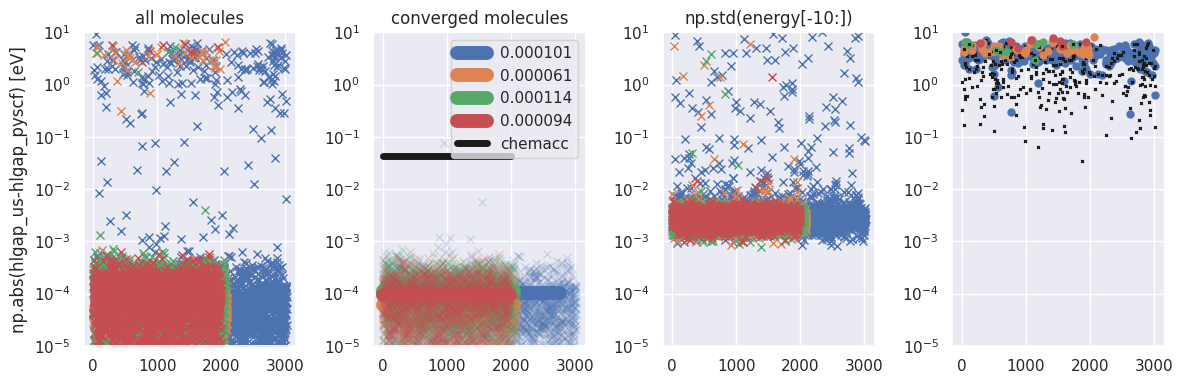

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

fig, ax = plt.subplots(1,4, figsize=(12,4))
i = 0
for df in dfs:  # find the ones that ran pyscf 
  if "pyscf_time" in [str(a) for a in df.keys()]:

    diff = np.abs(df["pyscf_hlgap"]-df["hlgap"])
    ax[0].plot(diff, 'x')
    energies = [np.fromstring( df["energies"][i][1:-1], sep=" ", dtype=np.float64)[-10:] for i in range(df.shape[0])]
    std = np.std(energies, axis=1)
    ax[2].plot(std, 'x')
    ax[1].plot(diff[std<1], "C%ix"%i, alpha=0.2)
    ax[1].plot([0, diff[std<1].size], [np.mean(diff[std<1]), np.mean(diff[std<1])], "C%i"%i, lw=10, label="%5f"%(np.mean(diff[std<1])))
    ax[3].plot(df["pyscf_hlgap"][std>1], "C%io"%i, ms=5)
    ax[3].plot(df["hlgap"][std>1], "kx", ms=2)


    i+=1

ax[1].plot([0, diff.size], [0.043, 0.043], "k-", lw=5, label="chemacc")
for a in ax:
  a.set_yscale("log")
  a.set_ylim([1e-5, 1e1])
ax[0].set_ylabel("np.abs(hlgap_us-hlgap_pyscf) [eV]")

ax[1].legend()

ax[0].set_title("all molecules")
ax[1].set_title("converged molecules")
ax[2].set_title("np.std(energy[-10:])")

plt.tight_layout()

In [106]:
# dump dataset
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
df = pd.concat(dfs)
print(df.shape)

(421040, 18)


In [97]:
#energies = [np.fromstring( df["energies"][i][1:-1], sep=" ", dtype=np.float64)[-10:] for i in range(df.shape[0])]
energies = np.array( [np.fromstring(df["energies"].values[i][1:-1], sep=" ", dtype=np.float64) for i in tqdm(range(df.shape[0]))] )

std = np.std(energies[:, -10:], axis=1)

df["energy_std"] = std
df["converged"] = std < 1

df.to_csv("gdb9_run2.csv")

100%|██████████| 405095/405095 [00:05<00:00, 70800.70it/s]


In [100]:
df["converged"].shape


(405095,)

In [83]:
print("Ran %i calculations of which %i converged. (%.1f %%)"%(df.shape[0], np.sum(df["converged"]), np.sum(df["converged"])/df.shape[0]*100))
conv = df[df["converged"].values] 

hlgap       = conv["hlgap"]
pyscf_hlgap = conv["pyscf_hlgap"]

diff = hlgap - pyscf_hlgap 
diff = diff[diff==diff]

print("chemacc: \t%6f"% 0.043, "eV")
print("MAE: \t\t%6f"% np.mean(np.abs(diff)), "eV")
df.head()

Ran 341025 calculations of which 331528 converged. (97.2 %)
chemacc: 	0.043000 eV
MAE: 		0.000096 eV


,Unnamed: 0,smile,atoms,atom_positions,energies,nuclear_energy,times,homo,lumo,hlgap,N,mem_eri,mem_grid,pyscf_time,pyscf_energy,pyscf_homo,pyscf_lumo,pyscf_hlgap,energy_std,converged
0,0,Oc1cn(C=O)c(=O)o1,OCCNCOCOOHHH,"[5.307158541295298, -0.2710725989877668, 0.032...",[-32142.79854509 -11330.53928444 -14052.765312...,11984.847834,[ -600. 332000. -285100. 10000. ...,-3.041526,1.526724,4.568249,48,42467328,33968000,NaN,NaN,NaN,NaN,NaN,0.003138,True
1,0,Fc1cn(C=N)c(=O)o1,FCCNCNCOOHHH,"[5.915646550588271, -0.924114133164047, 1.5311...",[-32288.21870417 -11377.60076863 -14225.684540...,11938.652731,[ 900. 357400. -309900. 48100. -53600. ...,-2.810130,1.202763,4.012893,48,42467328,33968000,NaN,NaN,NaN,NaN,NaN,0.002479,True
2,0,On1onnc1=NN=C,ONONNCNNCHHH,"[-1.1076483232110368, 2.9387542554016437, -0.1...",[-32217.9236873 -12759.93463549 -12864.561710...,12358.990838,[ 200. 377700. -330300. 19700. -5600. ...,-3.166712,0.074426,3.241138,48,42467328,33968000,NaN,NaN,NaN,NaN,NaN,0.006510,True
3,0,FCC1(F)C(F)C1(F)F,FCCFCFCFFHHH,"[4.446043985775873, 0.9762374173227367, -0.445...",[-39717.60411453 -16311.50832062 -17541.432122...,13795.629922,[ 200. 364000. -317400. 9900. -11100. ...,-4.135856,4.695279,8.831135,48,42467328,33968000,NaN,NaN,NaN,NaN,NaN,0.003745,True
4,0,On1onnc1=NC=N,ONONNCNCNHHH,"[-3.869760252147238, 2.5431971932822224, 1.278...",[-32026.09029841 -12889.71064648 -12752.282349...,12167.368749,[ 300. 374100. -327600. 13500. -5200. ...,-3.524341,-0.196730,3.327611,48,42467328,33968000,NaN,NaN,NaN,NaN,NaN,0.002862,True


In [31]:
hlgap = df["hlgap"]
pyscf_hlgap = df["pyscf_hlgap"]
diff = hlgap-pyscf_hlgap
diff[diff==diff]
print(np.mean(np.abs(diff)))

0.07770031324078572


In [24]:
!ls -lah

total 539M
drwxr-xr-x  3 alexm all    7 Apr  2 19:40 .
drwxr-xr-x 19 alexm all   76 Apr  2 18:44 ..
-rwxr-xr-x  1 alexm all   54 Mar 29 20:06 clean.sh
-rw-r--r--  1 alexm all 519M Apr  2 19:40 gdb9_run2.csv
drwxr-xr-x  4 alexm all    2 Apr  2 18:37 generated
-rw-r--r--  1 alexm all 5.0M Mar 30 14:34 rhos_He2.npz
-rw-r--r--  1 alexm all 715K Apr  2 18:41 runs.ipynb
-rwxr-xr-x  1 alexm all    9 Mar 19 19:19 sizes.sh
-rw-r--r--  1 alexm all  15M Mar 30 14:14 unique.pkl


# [run1] GDB9 

['run2', 'run3']


KeyError: '0_6940'

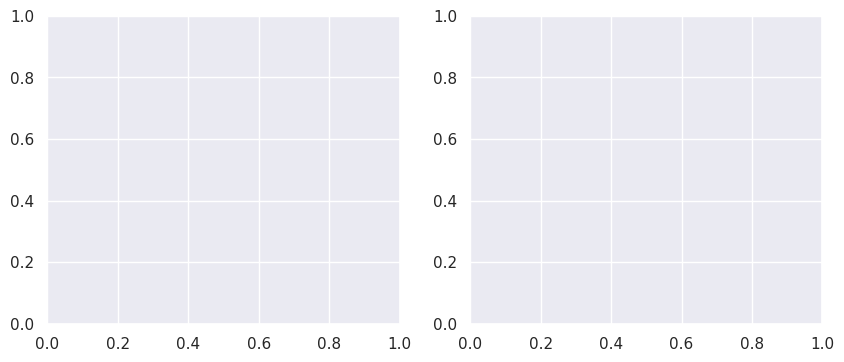

In [103]:
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

f = natsorted(os.listdir("../data/generated/"))[-100:]
print(f)

fig, ax = plt.subplots(1,2, figsize=(10, 4))

dct = {}

for a in f: 
  key = "_".join(a.split("_")[-2:])
  if key not in dct: dct[key]=[a]
  else: dct[key].append(a)

shapes = []
i = 0
#for _, a in enumerate(f):
for c in range(0, 444223, 6941):
  key = "%i_%i"%(c, c+6940)

  lst = []
  for a in dct[key]: 
    path = "../data/generated/%s/data.csv"%a
    if os.path.exists(path): 
      df = pd.read_csv(path)

  shapes.append(shape)
  if df.shape[1] == 96: continue 

  hlgap_err = np.abs(df.values[:, -1] - df.values[:, -4])

  energy = df.values[:, -32:-22].astype(np.float64)

  var = np.std(energy, axis=1)
  #print(var.shape, hlgap_err.shape)

  ax[0].plot(hlgap_err, 'C%ix'%(i%10), alpha=0.3, ms=2)#, label="MAE %5e"%np.mean(np.abs(hlgap_err)))
  ax[1].plot(hlgap_err[var < 1], 'C%ix'%(i%10), alpha=0.3, ms=2)#, label="MAE %5e"%np.mean(np.abs(hlgap_err[var<1])))

  raw_mean       = np.mean(np.abs(hlgap_err))
  converged_mean = np.mean(np.abs(hlgap_err[var<1]))

  ax[0].plot([0, 3000], [raw_mean, raw_mean], "C%i"%i, lw=5, label="mean %5e"%raw_mean)
  ax[1].plot([0, 3000], [converged_mean, converged_mean],  "C%i"%i, lw=5, label="mean %5e (converged)"%converged_mean)

  if i == 0: 
    ax[0].plot([0, 3000], [0.043, 0.043], label="chemical accuracy")
    ax[0].plot([0, 3000], [0.070, 0.070], label="GPS++ pcq 631-g*")
    ax[1].plot([0, 3000], [0.043, 0.043], label="chemical accuracy")
    ax[1].plot([0, 3000], [0.070, 0.070], label="GPS++ pcq 631-g*")
  ax[0].legend()
  ax[1].legend()
  ax[0].set_yscale("log")
  ax[1].set_yscale("log")

  i+=1

plt.legend()

#

In [23]:
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

f = natsorted(os.listdir("../data/generated/"))[-100:]
print(f)

dct = {}

for a in f: 
  key = "_".join(a.split("_")[-2:])
  if key not in dct: dct[key]=[a]
  else: dct[key].append(a)

full_hlgaps = []
hlgaps = []
i = 0
from tqdm import tqdm
#for _, a in enumerate(f):
for c in tqdm(range(0, 444223, 6941)):
  key = "%i_%i"%(c, c+6940)

  lst = []
  for a in dct[key]: 
    path = "../data/generated/%s/data.csv"%a
    if os.path.exists(path): 
      df = pd.read_csv(path)

  if df.shape[1] == 96: 
    hlgap = df.values[:, -1]
    energy = df.values[:, -28:-18].astype(np.float64)
  else: 
    hlgap = df.values[:, -4]
    energy = df.values[:, -32:-22].astype(np.float64)

  var = np.std(energy, axis=1)
  full_hlgaps.append(hlgap)
  hlgap = hlgap[var<10] 
  hlgaps.append(hlgap)


#

['394_GDB9_f32True_grid0_backendipu_326227_333167', '395_GDB9_f32True_grid0_backendipu_312345_319285', '396_GDB9_f32True_grid0_backendipu_284581_291521', '397_GDB9_f32True_grid0_backendipu_340109_347049', '398_GDB9_f32True_grid0_backendipu_333168_340108', '399_GDB9_f32True_grid0_backendipu_402578_409518', '400_GDB9_f32True_grid0_backendipu_374814_381754', '401_GDB9_f32True_grid0_backendipu_437283_444223', '402_GDB9_f32True_grid0_backendipu_360932_367872', '403_GDB9_f32True_grid0_backendipu_347050_353990', '404_GDB9_f32True_grid0_backendipu_423401_430341', '405_GDB9_f32True_grid0_backendipu_388696_395636', '406_GDB9_f32True_grid0_backendipu_353991_360931', '407_GDB9_f32True_grid0_backendipu_409519_416459', '408_GDB9_f32True_grid0_backendipu_381755_388695', '409_GDB9_f32True_grid0_backendipu_367873_374813', '410_GDB9_f32True_grid0_backendipu_395637_402577', '411_GDB9_f32True_grid0_backendipu_430342_437282', '412_GDB9_f32True_grid0_backendipu_416460_423400', '413_GDB9_f32True_grid0_backen

100%|██████████| 64/64 [00:07<00:00,  8.77it/s]


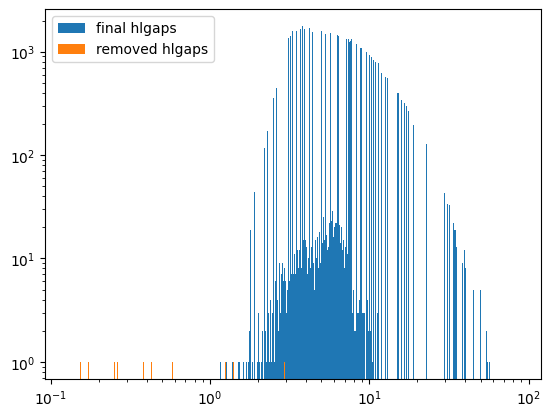

In [35]:
_fullhlgaps = np.concatenate(full_hlgaps)
_hlgaps = np.concatenate(hlgaps)
diff = np.setdiff1d(_fullhlgaps, _hlgaps)
unique_hlgaps = np.unique(_hlgaps).shape[0]
plt.hist(_hlgaps, bins=unique_hlgaps, label="final hlgaps")
plt.hist(diff, bins=unique_hlgaps, label="removed hlgaps")
plt.legend()
plt.yscale("log")
plt.xscale("log")

['394_GDB9_f32True_grid0_backendipu_326227_333167', '395_GDB9_f32True_grid0_backendipu_312345_319285', '396_GDB9_f32True_grid0_backendipu_284581_291521', '397_GDB9_f32True_grid0_backendipu_340109_347049', '398_GDB9_f32True_grid0_backendipu_333168_340108', '399_GDB9_f32True_grid0_backendipu_402578_409518', '400_GDB9_f32True_grid0_backendipu_374814_381754', '401_GDB9_f32True_grid0_backendipu_437283_444223', '402_GDB9_f32True_grid0_backendipu_360932_367872', '403_GDB9_f32True_grid0_backendipu_347050_353990', '404_GDB9_f32True_grid0_backendipu_423401_430341', '405_GDB9_f32True_grid0_backendipu_388696_395636', '406_GDB9_f32True_grid0_backendipu_353991_360931', '407_GDB9_f32True_grid0_backendipu_409519_416459', '408_GDB9_f32True_grid0_backendipu_381755_388695', '409_GDB9_f32True_grid0_backendipu_367873_374813', '410_GDB9_f32True_grid0_backendipu_395637_402577', '411_GDB9_f32True_grid0_backendipu_430342_437282', '412_GDB9_f32True_grid0_backendipu_416460_423400', '413_GDB9_f32True_grid0_backen

  3%|▎         | 2/64 [00:00<00:04, 12.75it/s]

[4.159746434231376 458.9022639800778 64.55988227303597 91.44147611501049
 54.0807561693458 50.66019923024673 17.195358840842125 4.715757301335758
 39.53069956984383 8.041974190627124 184.04509848313302 9.99597011546298]
[4.114205079962372 468.5115945437422 67.99682502351841 99.89247412982115
 54.26373471307617 51.15329256820326 16.646260583254872 4.650964252116638
 39.09628410159923 8.487746942615232 200.7259642521171 10.837276575729064]


  6%|▋         | 4/64 [00:00<00:06,  9.86it/s]

[4.01350190839695 514.9557729007637 80.85708492366398 88.90913645038181
 54.32433206106891 50.70133587786267 16.47104007633581 4.6310830152671585
 32.95636927480917 8.572876908396951 172.6450381679387 10.555582061068678]
[4.192112879884221 520.1483598649309 81.45178485287022 93.73164495899653
 54.283912204534566 50.466787264833606 17.052532561504915
 5.028871201157765 33.9196092619392 8.58880849011097 172.89573082489133
 10.172937771345879]


  9%|▉         | 6/64 [00:00<00:06,  9.33it/s]

[4.124951314508272 527.4307448880252 82.11798928919163 93.24255111976639
 54.09420642648477 50.85126582278495 16.779746835442953 5.351533592989286
 34.16587147030189 8.393816942551128 175.3630720545277 10.01582278481012]


 11%|█         | 7/64 [00:00<00:06,  9.27it/s]

[4.119274556526341 567.4459888800658 95.82377548318804 99.16973788721207
 55.018003706645636 50.078554408260544 16.929017738946182
 5.218136086841423 35.5766216574001 8.228170505692363 207.4762509928515
 9.78628541170245]


 12%|█▎        | 8/64 [00:00<00:06,  9.27it/s]

[4.144111405835546 567.1952519893889 95.4426525198942 98.98543766578234
 54.73554376657838 50.41689655172419 16.828275862068864 4.877320954907189
 36.364933687002605 8.118938992042441 209.6395225464195 10.036339522546406]


 14%|█▍        | 9/64 [00:00<00:05,  9.25it/s]

[4.181682242990652 570.7477703604802 97.4134846461951 102.08077436582086
 55.16240320427232 50.81684913217615 16.26651535380497 5.755941255006676
 36.791535380507355 8.066168224299064 206.01538050734288
 10.284192256341791]


 16%|█▌        | 10/64 [00:01<00:05,  9.26it/s]

[4.117242309767937 591.8056125202374 97.51332973556406 94.18518618456562
 54.27703723691302 50.4205612520237 17.16524554776026 5.2074743658931455
 36.239530491095564 8.214139233675128 206.90286022665947
 10.036103615758247]


 17%|█▋        | 11/64 [00:01<00:05,  9.32it/s]

[4.215345699831362 643.8352164137157 112.9208263069141 94.66183249016301
 54.387802136031524 50.58209668352996 17.350309162450746 5.670741989881952
 38.774170882518376 8.764024732996035 184.6539347948291 10.221641371557055]
[4.302759601706972 659.9658036984353 110.15081081081101 91.70697012802268
 54.471436699857655 50.98975817923191 16.920512091038372 5.47601706970128
 38.81285917496445 8.741735419630155 188.1344238975816 10.65897581792321]


 19%|█▉        | 12/64 [00:01<00:05,  9.47it/s]

[4.1766685361749785 640.2210039259679 111.90650588895184 92.91786315199076
 54.343129556926556 51.00762759394278 17.46180594503634 5.806337633202461
 39.428098710039436 8.788586651710578 185.34043746494672
 11.171480650588903]


 23%|██▎       | 15/64 [00:01<00:05,  9.75it/s]

[4.164922206506363 652.3973691654891 113.88820367751066 89.18019801980209
 54.09205091937769 51.17454031117386 17.403677510608116 5.794115983026892
 38.971513437058036 8.784893917963208 186.67680339462493
 11.701046676096187]
[4.300709018718088 658.6435053885413 109.89895065229709 90.05263754963127
 54.36647759500853 50.82731140102102 17.376035167328396 5.9010777084515
 39.16080544526381 8.99478162223485 184.97458876914376 10.832785025524647]
[4.270097198399085 661.1087764436824 112.91595197255604 90.94676958261853
 54.270411663807955 51.083018867924444 16.923413379073693
 5.5686678101772475 38.87258433390512 9.029988564894241 189.63233276157771
 10.585477415666087]


 28%|██▊       | 18/64 [00:01<00:03, 12.52it/s]

[4.109784946236558 715.7828315412191 128.81534050179212 89.9024731182798
 54.239498207885426 50.84591397849461 17.029068100358387 5.516523297491035
 38.72971326164885 8.287885304659495 239.49483870967674 8.537706093189938]
[4.121824686940966 701.4583184257608 132.28987477638617 99.53266547406075
 54.760787119856914 50.60171735241507 16.196672629695847 4.870161001788899
 37.58533094812173 8.634847942754924 239.58958855098382 9.755921288014335]


 31%|███▏      | 20/64 [00:01<00:03, 12.12it/s]

[4.1375133594585 696.5905949412186 130.8661560384752 100.69130744567131
 54.60185251157823 50.96847167794784 16.21282508015673 5.097328108300674
 38.13808336302115 8.643462771642321 239.0620947630924 9.834520840755259]


 34%|███▍      | 22/64 [00:02<00:03, 11.85it/s]

[4.096316165951352 703.4139484978538 132.07528612303295 97.80003576537922
 54.06434191702436 50.91587982832615 16.80157367668096 5.739663805436333
 37.6731759656652 8.846459227467816 239.02879113018557 9.262052932761105]
[4.129714487134297 680.1319351427557 131.45664434261502 100.49404300317244
 55.034050052872644 50.843003172365144 16.132499118787415
 5.633662319351416 38.277017976736 8.623193514275645 239.49168135354276
 9.647726471624953]
[4.170517363571937 681.951452870305 129.45283486888707 105.32161587526576
 55.12501771793052 50.88738483345147 16.38143160878807 5.414493267186383
 38.604925584691784 8.3343373493976 241.457547838412 10.457583274273562]


 38%|███▊      | 24/64 [00:02<00:03, 11.49it/s]

[4.112977676882331 778.5967839576247 150.78914112750658 95.25955353764654
 54.725955353764554 51.50264850548619 16.103859250851304 5.897351494513801
 38.46696935300789 13.573363601967479 219.74264093832724
 10.392243662504736]
[4.245121480910151 800.6933281912836 154.87616660239135 100.21396066332446
 55.57917470111854 50.906826070188956 15.363401465483994
 6.3250674893945344 39.18337832626302 10.6531045121481 219.50817585807897
 9.669379097570362]


 41%|████      | 26/64 [00:02<00:03, 12.00it/s]

[4.40079878280715 771.5579688094329 152.70912894636754 109.08505135032335
 54.98771395968039 50.600722708254054 16.80616203879799 5.799809813617348
 39.09901103081024 12.454089007227086 219.435032331685 9.710726511981742]


 44%|████▍     | 28/64 [00:02<00:02, 12.49it/s]

[4.3821197102554335 773.5079298513148 152.93309187952713
 107.54898970644325 55.317270301182056 50.59039268013733
 16.157186427754496 5.780861608844831 38.95775829203202 13.1927182615326
 219.96427754479575 10.21494471978648]
[4.225908372827802 826.7779620853086 154.20347551342792 101.89640600315944
 54.720300157977846 50.76394154818331 16.395853080568735 5.471563981042653
 39.552132701421804 12.813428120063197 219.5123617693521 9.559636650868875]
[4.290608160123174 791.1795612009248 153.29591993841427 104.2525789068512
 54.91882217090064 50.639953810623524 16.37702078521935 6.1316397228637625
 39.34557351809082 13.568552732871433 218.5020400307928 10.272671285604302]


 47%|████▋     | 30/64 [00:02<00:02, 12.79it/s]

[4.358720487433362 775.9277227722763 155.4923838537702 105.1552551408987
 55.4793221629854 50.60426504188873 16.019078446306157 5.571439451637484
 39.244668697638936 9.060091393754764 218.85514089870568
 10.448933739527785]
[4.345751138088019 770.994044006069 152.216540212443 105.56160849772388
 54.936153262519014 51.0680955993929 16.152883156297396 5.70686646433992
 39.18251138088008 12.524430955993934 218.98842943854316 10.54791350531107]


 50%|█████     | 32/64 [00:02<00:02, 13.23it/s]

[4.222322193658941 910.4682947729234 176.97780634104532 95.95394173093422
 55.64961439588684 50.57257926306765 16.142287917737843 5.73688946015425
 40.56666666666668 13.127506426735199 244.79318766066845 10.49884318766067]


 53%|█████▎    | 34/64 [00:02<00:02, 14.54it/s]

[4.085996649916252 810.9855946398661 174.75943048576207 86.0791959798996
 55.3212395309882 50.757185929648216 16.20757118927974 5.858994974874386
 38.72482412060297 13.527772194304843 243.0545058626467 8.910552763819084]
[4.139518413597735 888.1338526912206 174.43151558073646 96.96349150141654
 55.56951133144479 50.29996458923512 16.044759206798876 5.592174220963174
 38.44104107648729 12.870219546742208 243.5512039660052 9.718130311614711]


 56%|█████▋    | 36/64 [00:03<00:02, 13.90it/s]

[4.161067125645432 834.7781411359739 174.422065404475 103.93490533562797
 55.46767641996565 50.779070567986324 16.069053356282282 6.07583476764201
 38.87559380378653 13.360860585197917 242.51173838209985 9.695800344234081]


 59%|█████▉    | 38/64 [00:03<00:01, 13.46it/s]

[4.282496561210448 838.1479023383761 176.39195323246224 98.53566024759297
 55.80006877579103 50.43088033012376 15.84126547455296 5.614580467675378
 38.72169876203575 12.607909215955972 242.840508940853 9.40801237964237]
[4.183195307108346 841.8077639751544 174.99668737060054 98.0267425810904
 55.10645272601792 50.677743271221495 16.11887508626634 5.91476880607316
 39.66673567977915 13.603657694962067 243.16756383712953 9.631435472739815]
[4.2915438596491216 857.0292631578958 178.83059649122794
 105.60978947368417 55.36259649122807 50.775263157894734
 16.308070175438633 5.909192982456157 39.799719298245584 13.7475087719298
 243.8781052631578 9.327964912280699]


 62%|██████▎   | 40/64 [00:03<00:01, 13.16it/s]

[4.307161032351867 910.3900036350416 195.30319883678683 99.16557615412596
 55.473573246092144 50.75557978916747 15.961214103962167
 11.578662304616504 40.72377317339146 13.276299527444536
 229.58993093420622 9.73347873500545]
[4.547949291573446 960.1187546607028 202.24742729306487 99.64962714392242
 55.25932140193882 50.901603281133525 15.966442953020147 6.159433258762125
 40.44399701715133 13.21640566741238 220.19220730797878 9.946868008948536]


 66%|██████▌   | 42/64 [00:03<00:01, 13.01it/s]

[4.431529240828192 912.6794406102442 204.142208499818 104.44573192880499
 55.48652379222678 50.71681801670902 16.034725753723222 6.128841264075551
 40.260988013076656 10.88325463131129 220.32778786777985 9.818634217217571]


 69%|██████▉   | 44/64 [00:03<00:01, 13.12it/s]

[4.376040118870741 954.15486627043 200.1654903417533 104.29008172362578
 56.50401188707279 50.19947994056459 15.609843982169394 5.79784546805351
 40.776671619613744 10.447028231797903 219.89803120356578
 9.727786032689432]
[4.449609229624125 952.6165984369196 205.50788983997037 100.61034611090432
 55.266133234090084 50.62210643840705 16.26929661332339 6.102158541123919
 40.558689988835084 13.379196129512444 219.92396724972122
 9.860513583922591]
[4.3140098447557715 982.0021961378253 204.78617947747068
 100.53048087845494 55.69534267322981 50.75823551684958 15.706361226808003
 6.537599394168882 40.49307080651265 11.692843619840938 219.77156380159047
 10.118326391518375]


 72%|███████▏  | 46/64 [00:03<00:01, 13.10it/s]

[4.375056947608208 988.3069476082006 203.23667425968102 97.13151100987089
 55.385117691723664 50.681017463933124 16.30599848139714 6.108466211085784
 40.58158694001527 13.460060744115404 220.52528473804037 9.810858010630229]
[4.4160465990229225 972.380796692974 199.32074408117285 103.3369409996243
 55.767004885381425 50.9743329575347 15.625930101465647 5.9552048102217086
 40.16057872980086 13.376888387824124 220.0152950018787 9.640248027057508]


 75%|███████▌  | 48/64 [00:04<00:01, 13.31it/s]

[4.268705784436123 1060.1174365376612 232.30241364960474 96.1504369538077
 55.81244277985847 50.47831876820633 15.666749895963411 6.082646691635446
 42.38647523928429 14.98780690803162 284.23237619642197 9.57898460258012]


 78%|███████▊  | 50/64 [00:04<00:00, 14.44it/s]

[4.115475223395606 1033.3919577579222 227.92408610885448 89.0876523151911
 54.597359870024384 51.063484971567824 16.766978066612527
 6.492485783915521 40.31819658813975 15.018602761982077 284.1382209585707
 7.383915515840777]
[4.050566343042074 1021.3449838187713 224.724190938511 93.73964401294496
 55.78907766990301 50.88389967637543 15.758535598705548 6.147168284789632
 40.67018608414243 14.898139158576054 284.396601941747 9.097006472491913]


 81%|████████▏ | 52/64 [00:04<00:00, 13.98it/s]

[4.205103280680436 1019.8173754556512 226.54665856622069 96.79331713244233
 55.20522478736323 50.910044552450415 16.516686917780504
 6.3830295666261545 40.502227622519186 14.64993924665857 284.5976913730255
 8.906480356419603]


 84%|████████▍ | 54/64 [00:04<00:00, 13.59it/s]

[4.095132743362822 1002.4325020112641 227.14340305711963
 100.62992759452939 56.22489943684632 50.61625100563159 15.386162510056336
 6.071238938053105 41.075744167337064 14.998873692678963 283.9883748994365
 8.986122284794863]
[4.351859861591698 1129.2444204152243 256.3848183391006 96.30860726643597
 55.117128027681474 50.980709342560615 16.152119377162624
 14.343425605536313 43.85380622837372 14.381920415224904
 259.06695501730127 8.983347750865047]
[4.2141501294219115 1137.0033218291653 258.59236410698884
 95.79253666954281 55.35427092320968 50.94270923209672 15.903710094909421
 6.565875754961191 42.623554788610996 14.008239861949937
 252.92372735116433 8.677049180327884]


 88%|████████▊ | 56/64 [00:04<00:00, 13.78it/s]

[4.341038739889323 1106.2851426138807 258.48888888888905
 101.03839931885906 55.28143891017449 50.49893571732651 16.58620689655175
 6.41868880374627 42.548914431673076 14.133248190719458 253.64729672200943
 8.72656449553001]
[4.40832973672853 1125.9934397928348 264.04648252050055 99.24924471299094
 55.579628830384095 50.91782477341389 15.788088044885656 6.422442813983597
 43.554898575744495 15.192188174363364 253.52740612861464
 8.675097108329743]


 91%|█████████ | 58/64 [00:04<00:00, 13.90it/s]

[4.299355946758257 1122.3023185916684 261.5938170888796 101.65826534993556
 55.48269643623875 50.93598110777162 15.925289823958815 6.220008587376562
 43.136367539716574 11.509102619149854 253.95869471876344
 8.954057535422942]
[4.1544000000000105 1236.312282352942 294.56959999999975 99.74691764705882
 55.2073882352941 50.634917647058884 16.102964705882364 6.573082352941173
 43.262211764705825 14.402588235294106 291.24390588235286
 8.649882352941182]


 94%|█████████▍| 60/64 [00:04<00:00, 14.37it/s]

[4.103988603988609 1254.7389363722684 297.31723646723657 95.81362773029433
 55.55251661918323 50.803846153846095 15.756172839506197 6.379724596391256
 44.10161443494764 14.754653371320014 291.4447768281101 8.715716999050354]
[4.107166430928807 1236.2265440829785 295.81145685997126 98.54870344177274
 55.312116925978344 51.49174917491752 15.339462517680355 6.619943422913724
 45.00942951438006 14.61933050447903 291.3415370108437 9.633097595473828]


 97%|█████████▋| 62/64 [00:05<00:00, 14.74it/s]

[4.376537698412707 1346.863244047616 332.2605654761904 96.12470238095244
 55.807291666666636 50.95153769841271 15.86369047619052 10.324305555555542
 46.30828373015873 14.341468253968234 253.99925595238057 8.91125992063493]
[4.3266567754698375 1338.0816518298705 328.900197823937 102.54010880316528
 55.58822947576656 50.81132542037585 15.64416419386746 10.250296735905076
 45.35227497527205 14.376706231453994 253.71810089020767 9.154698318496532]


100%|██████████| 64/64 [00:05<00:00, 12.40it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4.087258064516129 1429.1441397849449 370.481075268817 92.29602150537617
 56.12424731182781 50.835860215053714 15.440268817204348 11.53849462365592
 46.99150537634403 13.504838709677426 322.9146236559147 9.375806451612911]


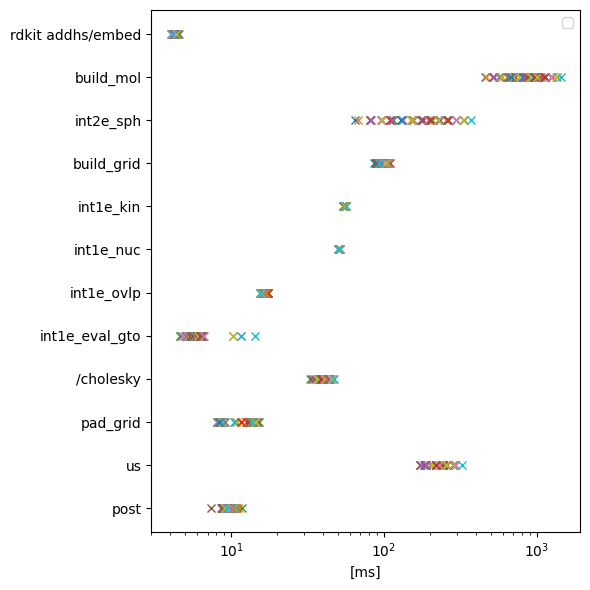

In [62]:
import numpy as np # do statistics one time ; plot time of each component for each of the 64 runs
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

f = natsorted(os.listdir("../data/generated/"))[-100:]
print(f)

dct = {}

for a in f: 
  key = "_".join(a.split("_")[-2:])
  if key not in dct: dct[key]=[a]
  else: dct[key].append(a)

fig, ax = plt.subplots(1,1, figsize=(6,6))
full_hlgaps = []
hlgaps = []
i = 0
from tqdm import tqdm
#for _, a in enumerate(f):
for c in tqdm(range(0, 444223, 6941)):
  key = "%i_%i"%(c, c+6940)

  lst = []
  for a in dct[key]: 
    path = "../data/generated/%s/data.csv"%a
    if os.path.exists(path): 
      df = pd.read_csv(path)

  if df.shape[1] == 96: 
    times = df.values[:, -12:] # times 
  else: 
    continue 


  plt.plot(np.mean(times[1:], axis=0), -np.arange(times.shape[1]), 'x')
  print(np.mean(times[1:], axis=0))
  i+=1

plt.legend()
plt.xscale("log")
plt.xlabel("[ms]")
#plt.ylabel("Operation num")

ax.set_yticks(-np.arange(12), ["rdkit addhs/embed",
"build_mol",
"int2e_sph",
"build_grid",
"int1e_kin",
"int1e_nuc",
"int1e_ovlp",
"int1e_eval_gto",
"/cholesky",
"pad_grid",
"us",
"post"
])


plt.tight_layout()



['394_GDB9_f32True_grid0_backendipu_326227_333167', '395_GDB9_f32True_grid0_backendipu_312345_319285', '396_GDB9_f32True_grid0_backendipu_284581_291521', '397_GDB9_f32True_grid0_backendipu_340109_347049', '398_GDB9_f32True_grid0_backendipu_333168_340108', '399_GDB9_f32True_grid0_backendipu_402578_409518', '400_GDB9_f32True_grid0_backendipu_374814_381754', '401_GDB9_f32True_grid0_backendipu_437283_444223', '402_GDB9_f32True_grid0_backendipu_360932_367872', '403_GDB9_f32True_grid0_backendipu_347050_353990', '404_GDB9_f32True_grid0_backendipu_423401_430341', '405_GDB9_f32True_grid0_backendipu_388696_395636', '406_GDB9_f32True_grid0_backendipu_353991_360931', '407_GDB9_f32True_grid0_backendipu_409519_416459', '408_GDB9_f32True_grid0_backendipu_381755_388695', '409_GDB9_f32True_grid0_backendipu_367873_374813', '410_GDB9_f32True_grid0_backendipu_395637_402577', '411_GDB9_f32True_grid0_backendipu_430342_437282', '412_GDB9_f32True_grid0_backendipu_416460_423400', '413_GDB9_f32True_grid0_backen

100%|██████████| 64/64 [00:04<00:00, 13.50it/s]


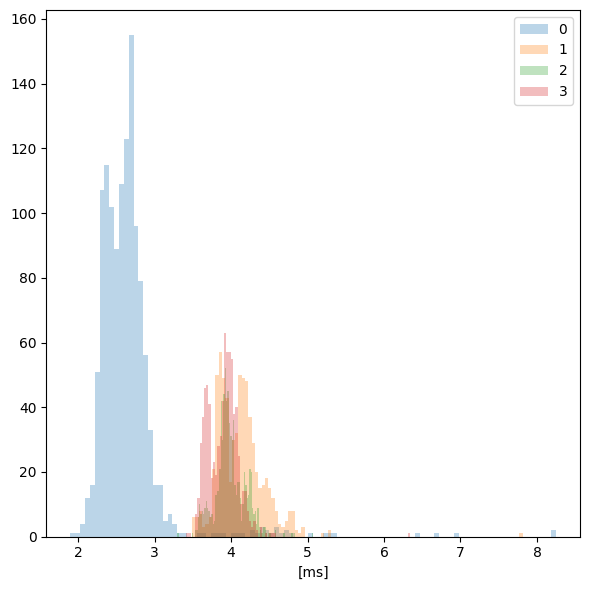

In [80]:
import numpy as np # do statistics one time ; plot time of each component for each of the 64 runs
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

f = natsorted(os.listdir("../data/generated/"))[-100:]
print(f)

dct = {}

for a in f: 
  key = "_".join(a.split("_")[-2:])
  if key not in dct: dct[key]=[a]
  else: dct[key].append(a)

fig, ax = plt.subplots(1,1, figsize=(6,6))
full_hlgaps = []
hlgaps = []
i = 0
from tqdm import tqdm
#for _, a in enumerate(f):
for c in tqdm(range(0, 444223, 6941)):
  key = "%i_%i"%(c, c+6940)

  lst = []
  for a in dct[key]: 
    path = "../data/generated/%s/data.csv"%a
    if os.path.exists(path): 
      df = pd.read_csv(path)

  if df.shape[1] == 98: 
    pyscf_time = df.values[3:, -8] 
    pyscf_time[pyscf_time>10000] = 0
  else: 
    continue


  plt.hist(pyscf_time, bins=100, alpha=0.3, label="%i"%i)
  i+=1

plt.legend()
plt.xlabel("[ms]")
#plt.ylabel("Operation num")

plt.tight_layout()


# [run0] GDB 9 (~200k)


Started script wrong, going to v1. Keeping notes. 

In [ ]:
# how to load data 
!pip install gdown 
gdown asdjkasjdk
import numpy 
np.load("gdb9_v0.npz")

Notes:
- Download link: GOOGLE DRIVE
- Molecules: ~ 200k out of 400k. 
- <font color="red">Tests:</font> Ran with `-pyscf` on 1 IPU on each pod16w. PySCF converged "worked" on 7000 of (400000/16) molecules. On those our hlgap_error was ~7e-5 MAE. (OBS: Assuming gdb9 is nort sorted this test was not on uniform random subset). 
- Time/mol: pyscf ~ 10s (dominated by gc.collect) us ~300ms (sometimes 2s due to loading new binary when hydrogen_num changes). 
- Threads: 2
- Date: 4/2/2023
- Harware: 4 pod16w
- Github commit: https://github.com/graphcore-research/jaxdft-pre-experimental/commit/21a06fcb077de657ca306a83c2dfec9ebeb0868a

Things to fix:
- Each iteration saves DM, H, Vj. This doubled cycles at 0% utilization due to jax bug; fixing this will roughly half time/mol. 
- Integral code spends 200kb/tile on vertex code and stack; hacky fix to this will half memory consumption. 
- Data not sorted by number hydrogens; this will allow us to not reload binary for each molecule. 
- After fixing saving of DM/H/Vj get ~ 100M cycles; half othis is 50M eigh cycles at 1% utilization. If we overlap this with dft iteration we get another 2x. 

Script (run on each pod16w with 0,16,32,48) offset

```

tmux new-session -d -s 0 "TF_POPLAR_FLAGS=--executable_cache_path=\"_cache/\" taskset -c 0-14  python density_functional_theory.py -gdb 9 -pyscf -split 0 64 -threads 2 -generate -save -backend ipu -float32 -level 0 -plevel 0 -its 50 -ipumult"

for X in 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
do
        v1=$((X*15)) 
        v2=$((X*15 + 14))

        echo "$v1 $v2"
        tmux new-session -d -s $X "TF_POPLAR_FLAGS=--executable_cache_path=\"_cache/\" taskset -c $v1-$v2 python density_functional_theory.py -gdb 9 -split $X 64 -threads 2 -generate -save -backend ipu -float32 -level 0 -plevel 0 -its 50 |& tee tmp/gentest$X.txt "

```

## hlgap Error analysis

(17,) (17,)
(2857,) (2857,)
(36,) (36,)
(3156,) (3156,)


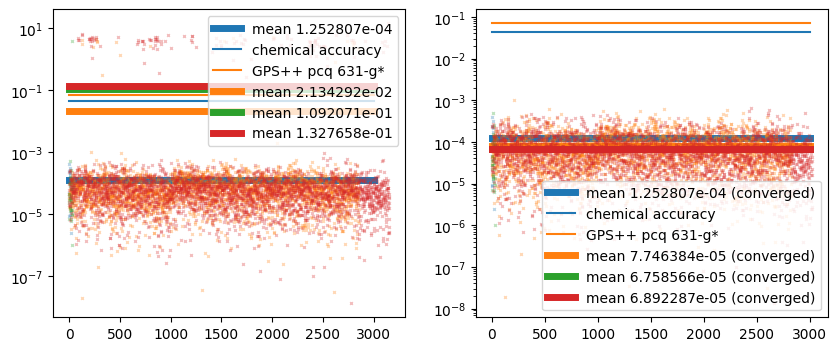

In [122]:
import matplotlib.pyplot as plt
import os 
import numpy as np 
from   natsort import natsorted
import pandas as pd 

# smiles, atom position, hlgap
f = natsorted(os.listdir("../data/generated/"))[-64:]
fig, ax = plt.subplots(1,2, figsize=(10, 4))

i = 0
for _, a in enumerate(f):
  df = pd.read_csv("../data/generated/%s/data.csv"%a)
  if df.shape[1] == 93: continue 


  hlgap_err = np.abs(df.values[:, -1] - df.values[:, -4])

  energy = df.values[:, -32:-22]


  var = np.std(energy, axis=1)
  print(var.shape, hlgap_err.shape)

  ax[0].plot(hlgap_err, 'C%ix'%i, alpha=0.3, ms=2)#, label="MAE %5e"%np.mean(np.abs(hlgap_err)))
  ax[1].plot(hlgap_err[var < 1], 'C%ix'%i, alpha=0.3, ms=2)#, label="MAE %5e"%np.mean(np.abs(hlgap_err[var<1])))

  raw_mean       = np.mean(np.abs(hlgap_err))
  converged_mean = np.mean(np.abs(hlgap_err[var<1]))

  ax[0].plot([0, 3000], [raw_mean, raw_mean], "C%i"%i, lw=5, label="mean %5e"%raw_mean)
  ax[1].plot([0, 3000], [converged_mean, converged_mean],  "C%i"%i, lw=5, label="mean %5e (converged)"%converged_mean)

  if i == 0: 
    ax[0].plot([0, 3000], [0.043, 0.043], label="chemical accuracy")
    ax[0].plot([0, 3000], [0.070, 0.070], label="GPS++ pcq 631-g*")
    ax[1].plot([0, 3000], [0.043, 0.043], label="chemical accuracy")
    ax[1].plot([0, 3000], [0.070, 0.070], label="GPS++ pcq 631-g*")
  ax[0].legend()
  ax[1].legend()
  ax[0].set_yscale("log")
  ax[1].set_yscale("log")

  i+=1

plt.legend()

# do pcq; translate from sto-3g to 6-31g*?

## Dump Data

0it [00:00, ?it/s]

213_GDB9_f32True_grid0_backendipu_6942_13883
[[-67687.74858445 -45243.45607988  55477.66413681  58038.1668603
   59265.89863089]
 [-76882.04225238 -76389.02400714 -77562.07107552 -70329.55399785
  -70193.36750141]
 [-60840.10125658 -74802.32999688 -70574.23984978 -71423.88243421
  -69940.39483648]
 ...
 [-73704.21170108 -73695.02767518 -68285.29899007 -54812.66387691
   40403.35877764]
 [ 49588.69007208  57986.20317165  53929.96519705 -40648.64145635
  -76588.93598198]
 [ 75420.97226097  88671.74835043 -75751.12930096 -87574.58332536
   79959.99575685]]


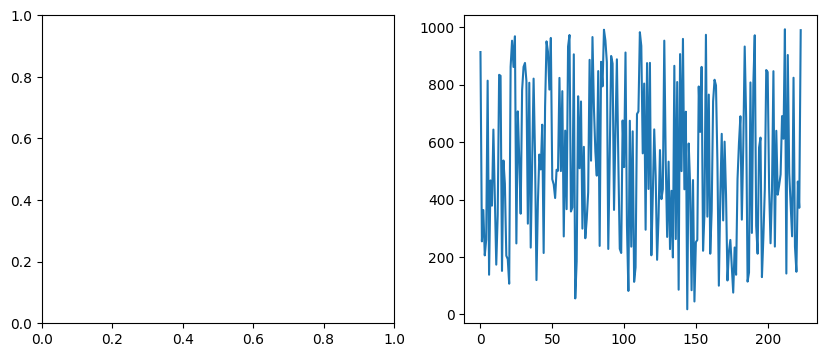

In [123]:
import matplotlib.pyplot as plt
import os 
import numpy as np 
from  natsort import natsorted
import pandas as pd 
from tqdm import tqdm 

f = natsorted(os.listdir("../data/generated/"))[-64:]
fig, ax = plt.subplots(1,2, figsize=(10, 4))

i = 0
hlgaps = []
for _, a in tqdm(enumerate(f)):
  df = pd.read_csv("../data/generated/%s/data.csv"%a)

  #print(df.loc[:, df.columns.str.startswith("Energy")].values[:, -10:])

  print(a)
  if df.shape == 93:

    energy = df.values[:, -33:-23].astype(np.float64)
    print(energy)
    var = np.std(energy, axis=1)
    vals = df.values[:,-1][var<1]


  else: 

    energy = df.values[:, -28:-23].astype(np.float64)
    print(energy)
    var = np.std(energy, axis=1)
    vals = df.values[:,-1][var<1]



  plt.plot(var[var<1000])
  break

  print(df.shape, vals.shape )

  hlgaps.append(vals)



#

(5937,)


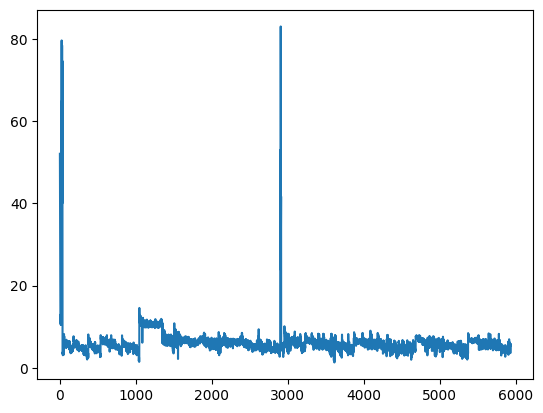

In [100]:
hl = np.concatenate(hlgaps)
print(hl.shape)
plt.plot(hl)